# Data collection from the input file

This code is used to analyse the geometries after xtb_dock - crest.
This part of code works with file `crest_ensemble.xyz` and should:
1. Extract geometry values (alpha, beta, distance, energy)
2. Add to the pandas dataframe along with the name of the folder
3. Add the corresponding `structure_x` code

In [1]:
import pandas as pd
import numpy as np
import os, re

Get the atom numbers from the Avogadro. Open file `best.xyz`, for example, in Avogadro and turn on the labels.
* loc_s - sulfur
* loc_cs - carbon in para position in the benzene sulfonate ring
* loc_n - nitrogen
* loc_cn - pos 4 in pyridinium ring

In [2]:
# global variables
loc_s = 127
loc_cs = 132
loc_n = 1
loc_cn = 9

Make sure that your file is named correctly (`crest_ensemble.xyz`)

In [3]:
df = pd.read_csv('crest_ensemble.xyz')

In [4]:
#reading number of atoms

for col in df.columns:
    atoms = int(col)
    
n_rows = atoms + 2

#Creating dataframes of separate atoms

df_s = df[df.index % n_rows == loc_s] # for S
df_cs = df[df.index % n_rows == loc_cs] # for C4 in sulfonate
df_n = df[df.index % n_rows == loc_n] # for N
df_cn = df[df.index % n_rows == loc_cn] # for C4 in pyridinium

#Formatting strings, splitting into columns, delete the element column, setting type to float

df_s= df_s[df_s.columns[0]].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_s = df_s.drop(columns=[0, 1]).astype('float64')

df_cs= df_cs[df_cs.columns[0]].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_cs = df_cs.drop(columns=[0, 1]).astype('float64')


df_n= df_n[df_n.columns[0]].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_n = df_n.drop(columns=[0, 1]).astype('float64')


df_cn= df_cn[df_cn.columns[0]].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_cn = df_cn.drop(columns=[0, 1]).astype('float64')

# xTB gfn2 energy values

df_e = df[df.index % n_rows == 0].astype('float64')

In [5]:
# Creating numpy arrays

arr_s = np.array(df_s)
arr_cs = np.array(df_cs)
arr_n = np.array(df_n)
arr_cn = np.array(df_cn)
arr_e = np.array(df_e)

In [6]:
# functions to calculate angle

def vectors(arr1, arr2):
    arr3 = arr2 - arr1
    return arr3

def vector_len(arr):
    v_len = np.sqrt((arr[:,0])**2 + (arr[:,1])**2 + (arr[:,2])**2)
    return v_len

def dot_product(arr1, arr2):
    dot_pr = arr1[:,0]*arr2[:,0] + arr1[:,1]*arr2[:,1] + arr1[:,2]*arr2[:,2]
    return dot_pr

def angle(arr1, arr2):
    cos_a = (dot_product(arr1, arr2))/(vector_len(arr1)*vector_len(arr2))
    result = np.degrees(np.arccos(cos_a))
    return result

In [7]:
# alpha angle
#vector N - C(N)
vector_N_Cn = vectors(arr_n, arr_cn)
     
#vector N - C(S)
vector_N_Cs = vectors(arr_n, arr_cs)
        
alpha_ang = np.around(angle(vector_N_Cn, vector_N_Cs), decimals=1)

# beta angle

vector_S_Cn = vectors(arr_s, arr_cn)
        
#vector S - C(S)
vector_S_Cs = vectors(arr_s, arr_cs)
        
beta_ang = np.around(angle(vector_S_Cs, vector_S_Cn), decimals=1)

# distance
ns_dist = np.around(vector_len(vectors(arr_n, arr_s)), decimals=1)

# combine into dataframe

stacked = np.column_stack((alpha_ang, beta_ang, ns_dist, arr_e)) # need this because numpy nicely transforms everything

inputs = pd.DataFrame(data=stacked, columns=['alpha_inp', 'beta_inp', 'distance_inp', 'energy_inp'])

inputs['rel_energy_inp_kcal'] = (inputs['energy_inp'] - inputs['energy_inp'].min())*627.509

In [8]:
# label each structure according to how the inputs were created
names = []
for _ in range(1, inputs.shape[0]+1):
    names.append(f'structure_{_}')
inputs['name'] = names

In [9]:
inputs

,alpha_inp,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,name
0,176.4,178.8,4.4,-311.160925,0.000000,structure_1
1,176.7,178.7,4.4,-311.160894,0.019810,structure_2
2,176.1,177.8,4.4,-311.160432,0.309789,structure_3
3,178.5,177.7,4.4,-311.160328,0.374949,structure_4
4,176.6,179.4,4.4,-311.160306,0.388930,structure_5
...,...,...,...,...,...,...
88,121.1,165.6,6.3,-311.140752,12.659266,structure_89
89,130.6,162.5,6.2,-311.140566,12.775776,structure_90
90,138.6,148.7,6.5,-311.140126,13.051760,structure_91
91,101.8,142.2,7.7,-311.138670,13.965627,structure_92


# Analysis of the geometric parameters

First let's look at the distributions of angles and distances

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

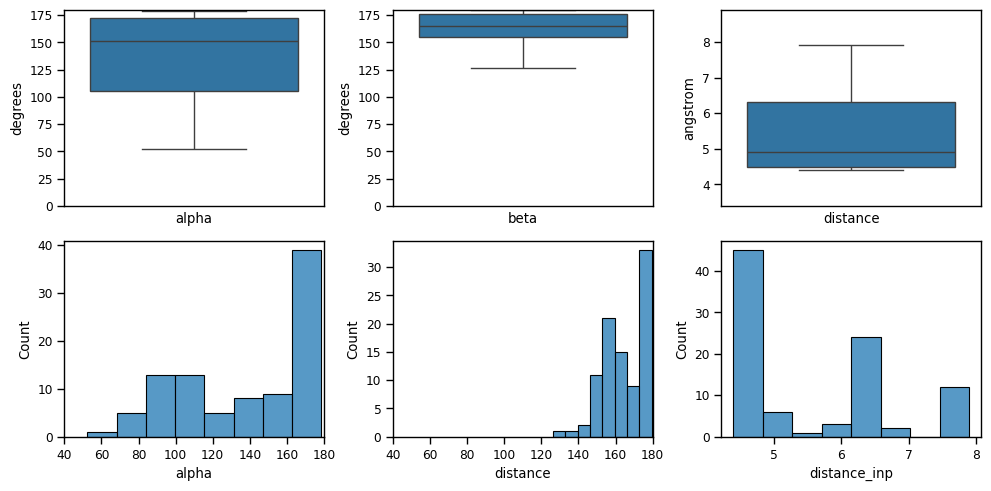

In [11]:
sns.set_context("paper")
#sns.set_style("white", {"axes.edgecolor": "black"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
axs = axs.flatten()

sns.boxplot(inputs['alpha_inp'], ax=axs[0])
ax=axs[0]
ax.set_ylabel('degrees')
ax.set_xlabel('alpha')
ax.set_ylim([0,180])
ax.set_xticks([])

sns.boxplot(inputs['beta_inp'], ax=axs[1])
ax=axs[1]
ax.set_ylabel('degrees')
ax.set_ylim([0,180])
ax.set_xlabel('beta')
ax.set_xticks([])

sns.boxplot(inputs['distance_inp'], ax=axs[2])
ax=axs[2]
ax.set_ylabel('angstrom')
ax.set_ylim([inputs['distance_inp'].min()-1, inputs['distance_inp'].max()+1])
ax.set_xlabel('distance')
ax.set_xticks([])

sns.histplot(inputs['alpha_inp'], ax=axs[3])
ax=axs[3]
ax.set_xlim([40,180])
ax.set_xlabel('alpha')

sns.histplot(inputs['beta_inp'], ax=axs[4])
ax=axs[4]
ax.set_xlim([40,180])
ax.set_xlabel('beta')

sns.histplot(inputs['distance_inp'], ax=axs[5])
ax.set_xlabel('distance')
plt.tight_layout()
plt.show()

Let's look at the angles more closely.

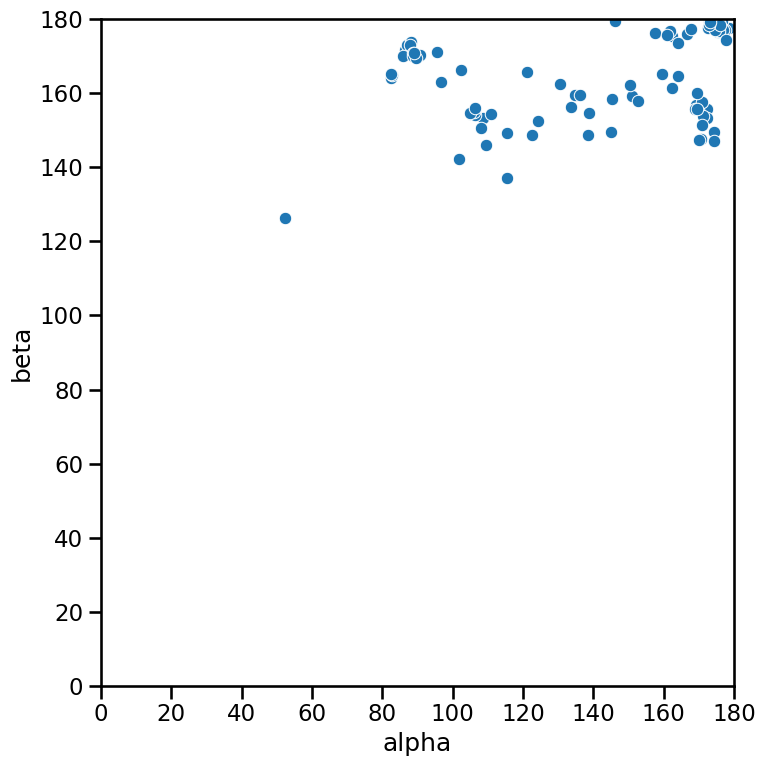

In [12]:
sns.set_context("talk")
#sns.set_style("whitegrid", {"axes.edgecolor": "black"})

fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

Zoom in area 140 - 180°

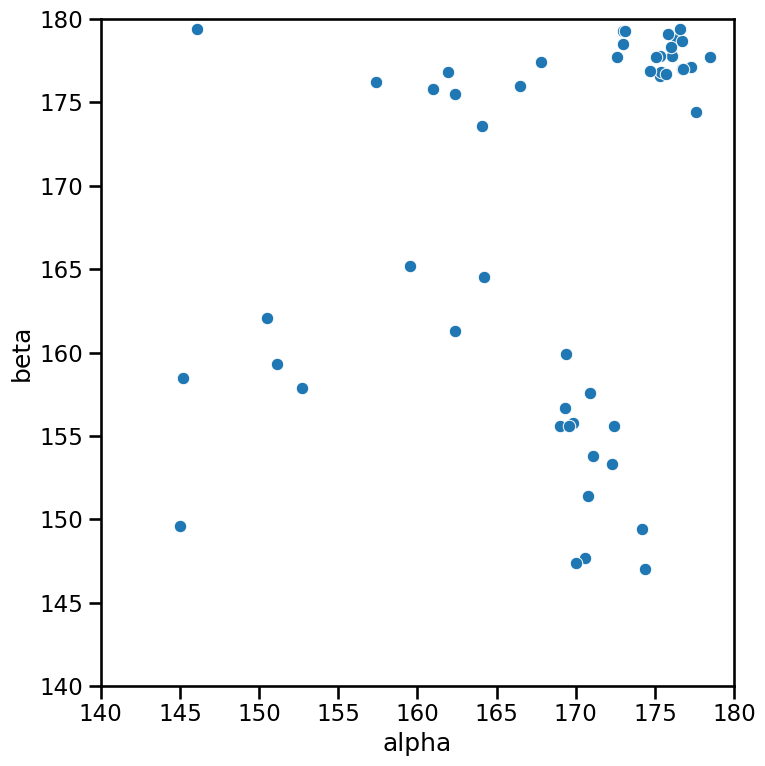

In [13]:
fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

Now with energy using different colors.

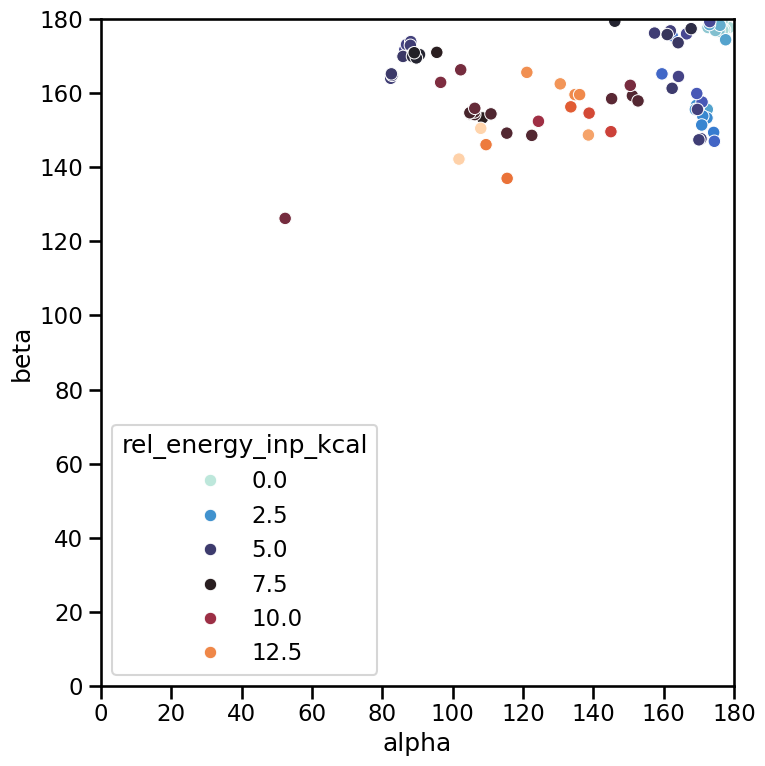

In [14]:
fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp', hue='rel_energy_inp_kcal', palette='icefire')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

Zoomed in

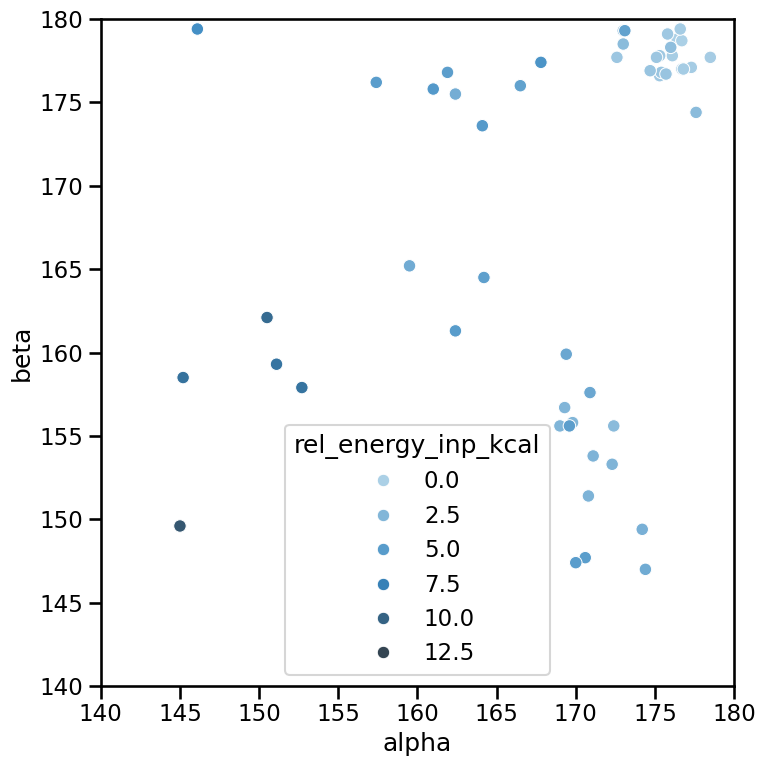

In [15]:
fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp', hue='rel_energy_inp_kcal', palette='Blues_d')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

# Clustering

Clustering will be performed using KMeans from scikit-learn (because it's simple and fast).

In [16]:
import warnings
from sklearn.cluster import KMeans

First we find the best number of clusters from the elbow rule, using only alpha and beta angles.

In [17]:
warnings.filterwarnings('ignore')
inertias = []
for i in range(1,11): # more than 10 clusters make no sense for 93 samples
    model = KMeans(n_clusters=i, random_state=123, max_iter=1000)
    model.fit(inputs[['alpha_inp', 'beta_inp']])
    inertias.append(model.inertia_)

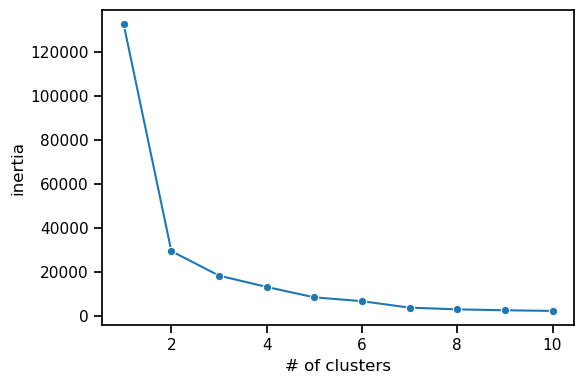

In [18]:
sns.set_context("notebook")
#sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=range(1,11), y=inertias, markers=True, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('inertia')
plt.tight_layout()
plt.show()

4 clusters look like a reasonable solution here, let's viasualize them

In [19]:
model = KMeans(n_clusters=4, random_state=123, max_iter=1000)
model.fit(inputs[['alpha_inp', 'beta_inp']])
inputs['cluster_inp'] = model.labels_

The following figure was created to include in the thesis, so it has different style/size. 
If you want to make high quality figures, use the code below as a template.

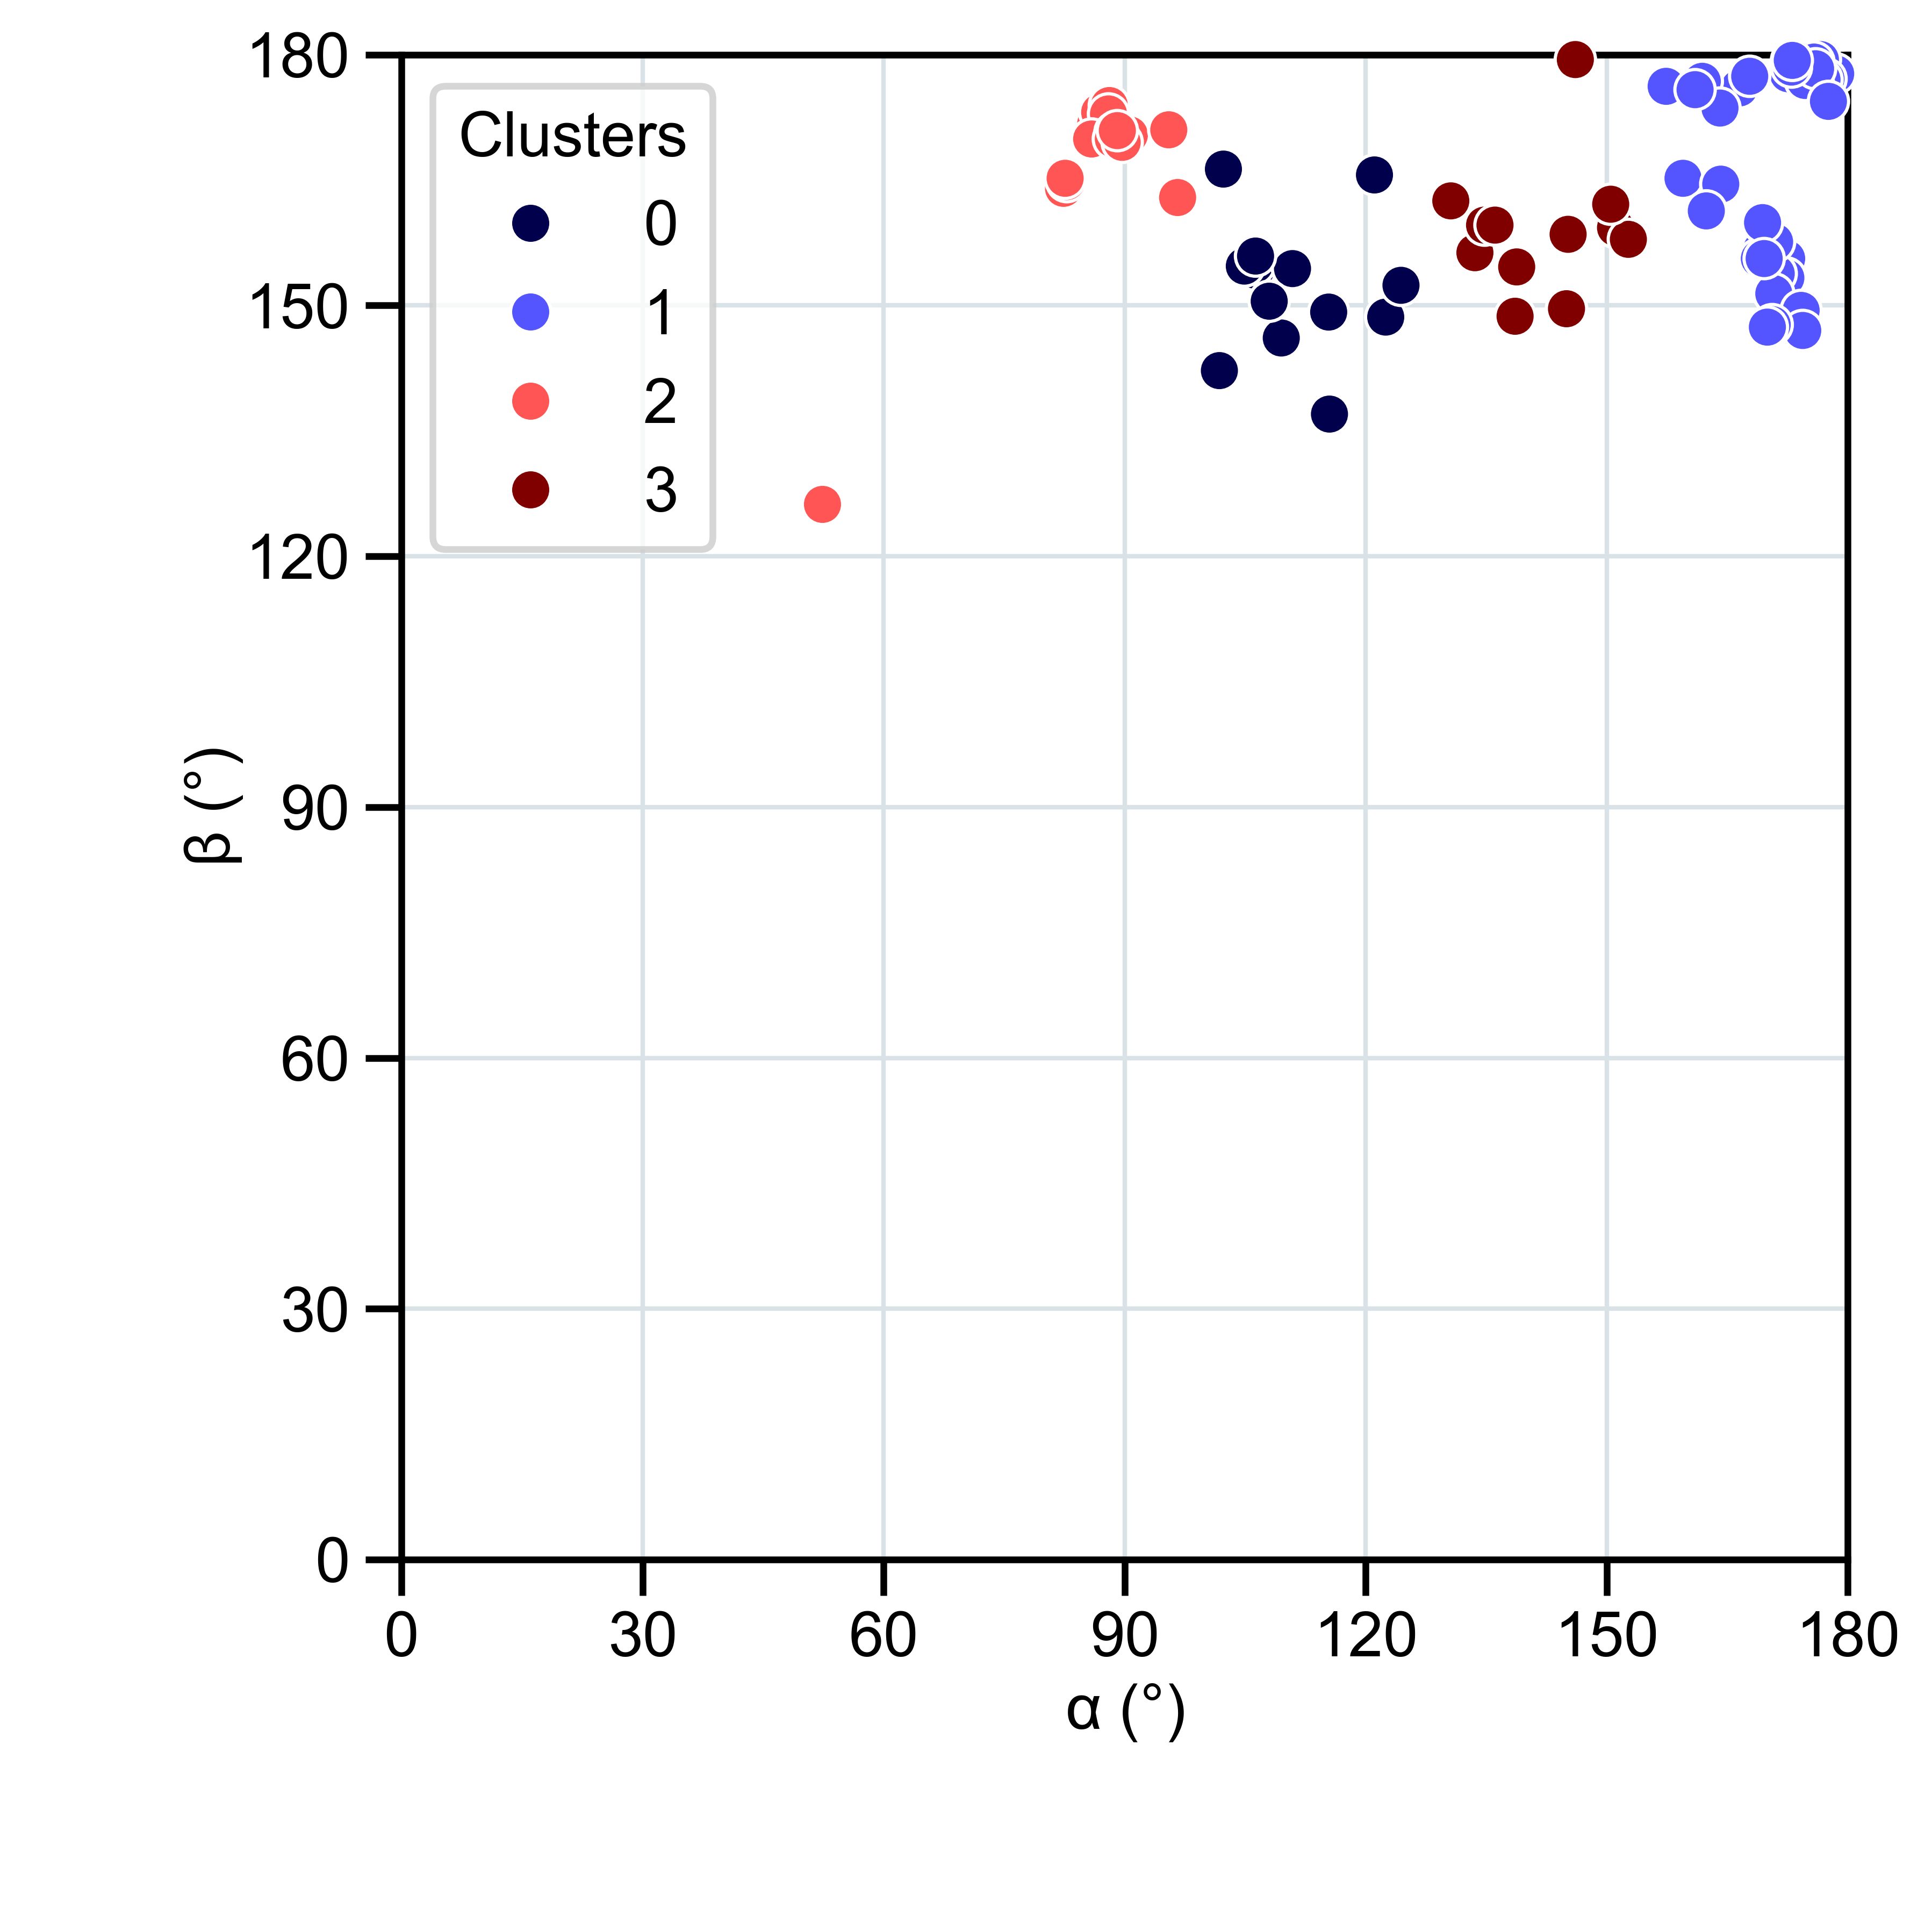

In [20]:
sns.set_context("talk")
#sns.set_style("whitegrid", {"axes.edgecolor": "black"})
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.fontset"] = 'custom'
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.bf"] = 'sans:bold'
plt.rcParams["mathtext.rm"] = 'serif'
fonts = {'fontsize': 14}

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp', hue='cluster_inp', palette='seismic', zorder=5, clip_on=False)
ax.set_axisbelow(True)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.grid(visible=True, which='major', axis='both', lw=1, c='#d9e2e6')

ax.set_xticks([0, 30, 60, 90, 120, 150, 180])
ax.set_yticks([0, 30, 60, 90, 120, 150, 180])

plt.tick_params(direction='out', length=8, color='black', width=1.5, labelsize=14)
plt.xlim(0, 180)
plt.ylim(0, 180)


plt.xlabel(r'$\alpha$ (°)', **fonts, labelpad=3)
plt.ylabel(r'$\beta$ (°)', **fonts, labelpad=0.15)

ax.legend(**fonts, loc='best', title='Clusters', title_fontsize=14)


plt.tight_layout()

#plt.savefig('iPr_xtb.svg', dpi='figure', format='svg', bbox_inches='tight')
plt.show()

Zoomed in

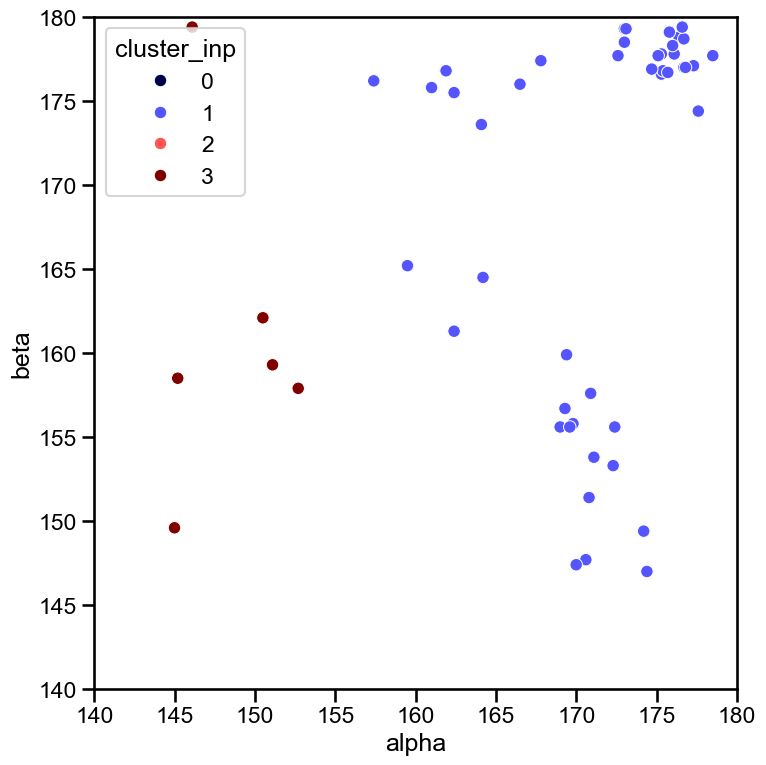

In [21]:
fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp', hue='cluster_inp', palette='seismic')


plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)


plt.tight_layout()
plt.show()

# Some statistics for each cluster

Red lines represent mean values of each distribution.

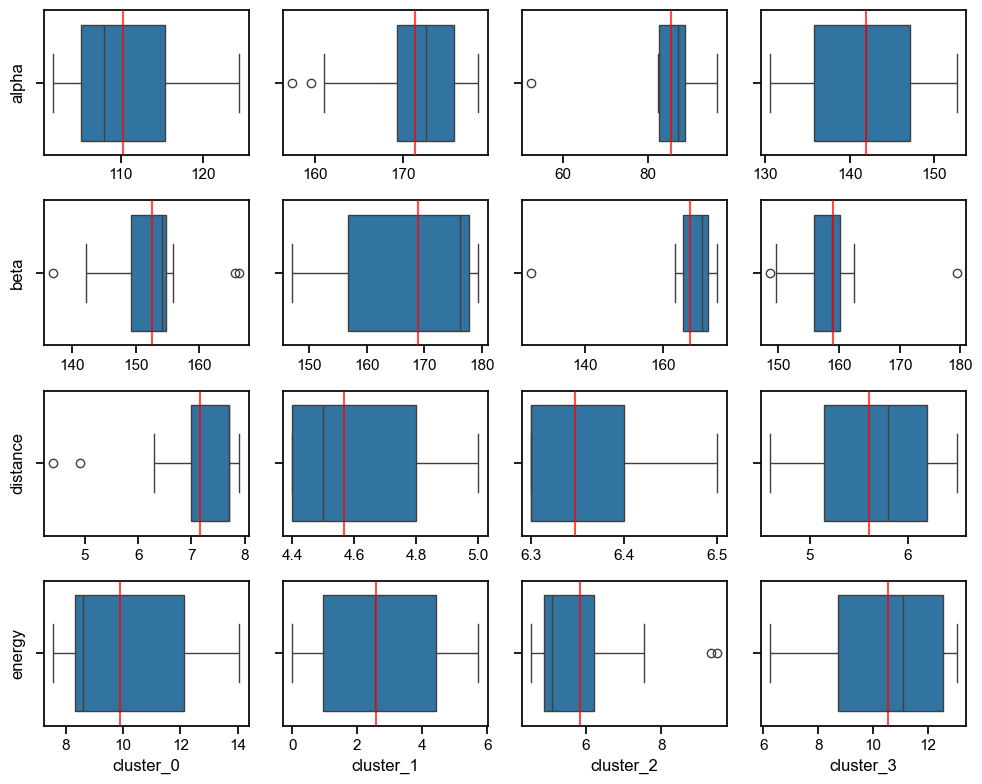

In [22]:
sns.set_context("notebook")
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,8), sharey=True)
axs = axs.flatten()

for i in range(4):
    data = inputs[inputs['cluster_inp']==i]
    
    sns.boxplot(data=data, x='alpha_inp', ax = axs[i])
    
    ax = axs[i]
    ax.set_xlabel('')
    ax.axvline(x=data['alpha_inp'].mean(), zorder=9, c='red', alpha=0.7)
    
for i in range(4):
    data = inputs[inputs['cluster_inp']==i]
    
    sns.boxplot(data=data, x='beta_inp', ax = axs[i+4])
    
    ax = axs[i+4]
    ax.set_xlabel('')
    
    ax.axvline(x=data['beta_inp'].mean(), zorder=9, c='red', alpha=0.7)
for i in range(4):
    data = inputs[inputs['cluster_inp']==i]
    
    sns.boxplot(data=data, x='distance_inp', ax = axs[i+8])
    
    ax = axs[i+8]
    ax.set_xlabel('')
    ax.axvline(x=data['distance_inp'].mean(), zorder=9, c='red', alpha=0.7)
    
for i in range(4):
    data = inputs[inputs['cluster_inp']==i]
    
    sns.boxplot(data=data, x='rel_energy_inp_kcal', ax = axs[i+12])
    
    ax = axs[i+12]
    ax.set_xlabel(f'cluster_{i}')
    ax.axvline(x=data['rel_energy_inp_kcal'].mean(), zorder=9, c='red', alpha=0.7)

ax = axs[0]
ax.set_ylabel('alpha')
ax = axs[4]
ax.set_ylabel('beta')
ax = axs[8]
ax.set_ylabel('distance')
ax = axs[12]
ax.set_ylabel('energy')
    
plt.tight_layout()
plt.show()


# Data collection of the output files

This part requires to perform the next step in the workflow. You must have: R2SCAN calculated SP energies for benzene, DCM and water, and correct SPH calculations from the xTB. If you want to remove some solvents, you will need to modify the "SPE for each solvent" part.
The algorithm iterates through folders `structure_x`, extracts geometry data from the xyz file, extracts R2SCAN-3c SP energy in vacuum and different solvents, extracts $\Delta G_{RRHO}$ values, and adds it as row to the pandas DataFrame along with structure.

In [23]:
# list of folders
folders = []
for dr in os.scandir():
    if dr.is_dir() and 'structure' in dr.name:
        folders.append(dr.name)

First we will create functions for each process (xyz file, out file etc.), then iterate through `folders` list executing those functions.

### Extracting geometry

In [24]:
def geometry_from_xyz(folder):
    pattern_xyz = 'struc_[0-9]+_r2scan_opt\.xyz'
    file_name = [i for i in os.listdir(f'{folder}/') if re.findall(pattern_xyz, i)][0] # get the name of correct xyz
    with open(f'{folder}/{file_name}', 'r', encoding='utf-8') as xyz:
        lines = xyz.readlines()
        no_of_atoms = int(lines[0][:-1]) # get number of atoms
        
        # get the lines containing the atoms we need
        
        n_coord = np.array([float(i) for i in lines[loc_n+1].strip().split()[1:]])
        cn_coord = np.array([float(i) for i in lines[loc_cn+1].strip().split()[1:]])
        s_coord = np.array([float(i) for i in lines[loc_s+1].strip().split()[1:]])
        cs_coord = np.array([float(i) for i in lines[loc_cs+1].strip().split()[1:]])
        
        # calculate the corresponding angles
        # alpha
        
        vector_n_cn = cn_coord - n_coord
        vector_n_cs = cs_coord - n_coord
        len_n_cn = np.sqrt(np.square(vector_n_cn).sum())
        len_n_cs = np.sqrt(np.square(vector_n_cs).sum())
        
        cos_a = np.dot(vector_n_cn, vector_n_cs)/(len_n_cn*len_n_cs)
        alpha = np.around(np.degrees(np.arccos(cos_a)), decimals=1)
        
        # beta
        
        vector_s_cn = cn_coord - s_coord
        vector_s_cs = cs_coord - s_coord
        len_s_cn = np.sqrt(np.square(vector_s_cn).sum())
        len_s_cs = np.sqrt(np.square(vector_s_cs).sum())
        
        cos_b = np.dot(vector_s_cs, vector_s_cn)/(len_s_cs*len_s_cn)
        beta = np.around(np.degrees(np.arccos(cos_b)), decimals=1)
        
        # distance
        dist = np.around(np.sqrt(np.square(n_coord - s_coord).sum()), decimals=1)
               
        
        
    return alpha, beta, dist

### SPE in vacuum

In [25]:
def r2scan_spe_vacuum(folder):
    pattern_out = 'struc_[0-9]+_r2scan_opt\.out'
    file_name = [i for i in os.listdir(f'{folder}/') if re.findall(pattern_out, i)][0] # get the name of correct out
    with open(f'{folder}/{file_name}', 'r', encoding='utf-8') as out:
        lines = out.readlines()
        for line in lines:
            if 'FINAL SINGLE POINT ENERGY' in line:
                energy_vacuum = re.findall(r'[-.\d]*[.][\d]+', line)
    return np.around(float(energy_vacuum[0]), decimals=6)

### $\Delta G_{RRHO}$ from single point hessian

In [26]:
def hess_reader(folder):
    pattern_out = 'struc_[0-9]+_r2scan_opt_bhess\.out'
    file_name = [i for i in os.listdir(f'{folder}/SPH/') if re.findall(pattern_out, i)][0] # get the name of correct out
    
    with open(f'{folder}/SPH/{file_name}', 'r', encoding='utf-8') as hess:
        lines = hess.readlines()
        for line in lines:
            if 'G(RRHO) contrib' in line:
                G_rrho = re.findall(r'[-.\d]*[.][\d]+', line)
        
    return np.around(float(G_rrho[0]), decimals=6)

### SPE for each solvent

In [27]:
def r2scan_spe_solvent(folder):
    energies = [folder]
    for solvent in solvents:
        with open(f'{folder}/{solvent}/{folder}_r2scan_{solvent}.out', 'r', encoding='utf-8') as opt:
            lines = opt.readlines()
            for line in lines:
                if 'FINAL SINGLE POINT ENERGY' in line:
                    energy_sol = re.findall(r'[-.\d]*[.][\d]+', line)
                    energies.append(np.around(float(energy_sol[0]), decimals=6))
    return energies
                    

In [28]:
solvents = ['benzene', 'CH2Cl2', 'water']
en = []
for folder in folders:
    energies = r2scan_spe_solvent(folder)
    en.append(energies)

In [29]:
solv_df = pd.DataFrame(en, columns=['name', 'benzene', 'CH2Cl2', 'water'])

### Iterating through the folders and combining the data

In [30]:
outputs = pd.DataFrame(columns=['name', 'alpha_opt', 'beta_opt', 'distance_opt', 'SPE_vac', 'dG'])
for folder in folders:
    alpha, beta, dist = geometry_from_xyz(folder)
    spe = r2scan_spe_vacuum(folder)
    dG = hess_reader(folder)
    
    outputs.loc[len(outputs.index)] = [folder, alpha, beta, dist, spe, dG]
    

In [31]:
outputs['energy_opt_vac'] = outputs['SPE_vac'] + outputs['dG']

In [32]:
combined = outputs.merge(solv_df, on='name')

In [33]:
combined['benzene_opt'] = combined['benzene'] + combined['dG']
combined['CH2Cl2_opt'] = combined['CH2Cl2'] + combined['dG']
combined['water_opt'] = combined['water'] + combined['dG']

In [34]:
combined.head(5)

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,benzene_opt,CH2Cl2_opt,water_opt
0,structure_1,169.9,176.1,4.6,-4651.819516,2.046003,-4649.773513,-4651.843632,-4651.868105,-4651.878492,-4649.797629,-4649.822102,-4649.832489
1,structure_10,169.9,176.1,4.6,-4651.819510,2.045981,-4649.773529,-4651.843633,-4651.868112,-4651.878501,-4649.797652,-4649.822131,-4649.832520
2,structure_11,171.9,177.6,4.6,-4651.819536,2.045704,-4649.773832,-4651.843657,-4651.868128,-4651.878510,-4649.797953,-4649.822424,-4649.832806
3,structure_12,171.5,179.5,4.6,-4651.819471,2.044866,-4649.774605,-4651.843760,-4651.868398,-4651.878851,-4649.798894,-4649.823532,-4649.833985
4,structure_13,171.5,179.5,4.6,-4651.819493,2.045063,-4649.774430,-4651.843747,-4651.868350,-4651.878790,-4649.798684,-4649.823287,-4649.833727


# Manually get cation and anion r2scan energies 

In [35]:
cation_dG = 1.020778
cation_spe_vac = np.around(cation_dG - 2042.082994076759, decimals=6)
cation_spe_benzene = np.around(cation_dG - 2042.112010110078, decimals=6)
cation_spe_CH2Cl2 = np.around(cation_dG - 2042.137675855720, decimals=6)
cation_spe_water = np.around(cation_dG - 2042.147422099356, decimals=6)

In [36]:
anion_dG = 0.993800
anion_spe_vac = np.around(anion_dG - 2609.616974162284, decimals=6)
anion_spe_benzene = np.around(anion_dG - 2609.655478543323, decimals=6)
anion_spe_CH2Cl2 = np.around(anion_dG - 2609.692657286503, decimals=6)
anion_spe_water = np.around(anion_dG - 2609.707742943956, decimals=6)

Calculate the association energies for each structure.

In [37]:
combined['association_vacuum'] = (combined['energy_opt_vac'] - (cation_spe_vac+anion_spe_vac))*627.509
combined['association_benzene'] = (combined['benzene_opt'] - (cation_spe_benzene+anion_spe_benzene))*627.509
combined['association_CH2Cl2'] = (combined['CH2Cl2_opt'] - (cation_spe_CH2Cl2+anion_spe_CH2Cl2))*627.509
combined['association_water'] = (combined['water_opt'] - (cation_spe_water+anion_spe_water))*627.509

In [38]:
combined.head(5)

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,benzene_opt,CH2Cl2_opt,water_opt,association_vacuum,association_benzene,association_CH2Cl2,association_water
0,structure_1,169.9,176.1,4.6,-4651.819516,2.046003,-4649.773513,-4651.843632,-4651.868105,-4651.878492,-4649.797629,-4649.822102,-4649.832489,-55.297976,-28.060947,-3.982800,5.081568
1,structure_10,169.9,176.1,4.6,-4651.819510,2.045981,-4649.773529,-4651.843633,-4651.868112,-4651.878501,-4649.797652,-4649.822131,-4649.832520,-55.308016,-28.075380,-4.000997,5.062115
2,structure_11,171.9,177.6,4.6,-4651.819536,2.045704,-4649.773832,-4651.843657,-4651.868128,-4651.878510,-4649.797953,-4649.822424,-4649.832806,-55.498151,-28.264260,-4.184858,4.882648
3,structure_12,171.5,179.5,4.6,-4651.819471,2.044866,-4649.774605,-4651.843760,-4651.868398,-4651.878851,-4649.798894,-4649.823532,-4649.833985,-55.983215,-28.854746,-4.880137,4.142814
4,structure_13,171.5,179.5,4.6,-4651.819493,2.045063,-4649.774430,-4651.843747,-4651.868350,-4651.878790,-4649.798684,-4649.823287,-4649.833727,-55.873401,-28.722969,-4.726398,4.304712


In [39]:
combined.sort_values(by='association_benzene').head(10)

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,benzene_opt,CH2Cl2_opt,water_opt,association_vacuum,association_benzene,association_CH2Cl2,association_water
25,structure_32,175.0,146.8,4.9,-4651.823922,2.046940,-4649.776982,-4651.846038,-4651.868306,-4651.877649,-4649.799098,-4649.821366,-4649.830709,-57.474804,-28.982758,-3.520953,6.198534
26,structure_33,174.9,147.0,4.9,-4651.823902,2.046939,-4649.776963,-4651.845973,-4651.868196,-4651.877519,-4649.799034,-4649.821257,-4649.830580,-57.462882,-28.942598,-3.452555,6.279483
3,structure_12,171.5,179.5,4.6,-4651.819471,2.044866,-4649.774605,-4651.843760,-4651.868398,-4651.878851,-4649.798894,-4649.823532,-4649.833985,-55.983215,-28.854746,-4.880137,4.142814
50,structure_55,171.6,179.5,4.6,-4651.819451,2.044871,-4649.774580,-4651.843734,-4651.868364,-4651.878814,-4649.798863,-4649.823493,-4649.833943,-55.967528,-28.835294,-4.855665,4.169170
4,structure_13,171.5,179.5,4.6,-4651.819493,2.045063,-4649.774430,-4651.843747,-4651.868350,-4651.878790,-4649.798684,-4649.823287,-4649.833727,-55.873401,-28.722969,-4.726398,4.304712
80,structure_82,158.6,172.9,4.6,-4651.819596,2.045191,-4649.774405,-4651.843644,-4651.867820,-4651.877975,-4649.798453,-4649.822629,-4649.832784,-55.857714,-28.578015,-4.313497,4.896453
68,structure_71,158.5,173.1,4.6,-4651.819578,2.045220,-4649.774358,-4651.843601,-4651.867751,-4651.877895,-4649.798381,-4649.822531,-4649.832675,-55.828221,-28.532834,-4.252001,4.964851
8,structure_17,171.0,179.4,4.6,-4651.818999,2.044853,-4649.774146,-4651.843204,-4651.867754,-4651.878168,-4649.798351,-4649.822901,-4649.833315,-55.695189,-28.514009,-4.484179,4.563245
44,structure_5,170.0,174.3,4.6,-4651.820501,2.046182,-4649.774319,-4651.844488,-4651.868841,-4651.879173,-4649.798306,-4649.822659,-4649.832991,-55.803748,-28.485771,-4.332322,4.766558
24,structure_31,172.2,146.8,4.9,-4651.822487,2.046472,-4649.776015,-4651.844695,-4651.866985,-4651.876308,-4649.798223,-4649.820513,-4649.829836,-56.868003,-28.433688,-2.985688,6.746349


# Combine inputs and outputs

Inputs = xTB calculation (GFN2 level), outputs = ORCA calculations (R2SCAN level)

In [40]:
inp_out = combined.merge(inputs, on='name')

In [41]:
inp_out.sort_values(by='association_benzene').head(10)

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,association_vacuum,association_benzene,association_CH2Cl2,association_water,alpha_inp,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp
25,structure_32,175.0,146.8,4.9,-4651.823922,2.046940,-4649.776982,-4651.846038,-4651.868306,-4651.877649,...,-57.474804,-28.982758,-3.520953,6.198534,170.9,157.6,4.8,-311.154701,3.905622,1
26,structure_33,174.9,147.0,4.9,-4651.823902,2.046939,-4649.776963,-4651.845973,-4651.868196,-4651.877519,...,-57.462882,-28.942598,-3.452555,6.279483,169.4,159.9,4.8,-311.154669,3.926167,1
3,structure_12,171.5,179.5,4.6,-4651.819471,2.044866,-4649.774605,-4651.843760,-4651.868398,-4651.878851,...,-55.983215,-28.854746,-4.880137,4.142814,175.1,177.7,4.4,-311.159437,0.933853,1
49,structure_55,171.6,179.5,4.6,-4651.819451,2.044871,-4649.774580,-4651.843734,-4651.868364,-4651.878814,...,-55.967528,-28.835294,-4.855665,4.169170,161.0,175.8,4.5,-311.152445,5.321841,1
4,structure_13,171.5,179.5,4.6,-4651.819493,2.045063,-4649.774430,-4651.843747,-4651.868350,-4651.878790,...,-55.873401,-28.722969,-4.726398,4.304712,172.6,177.7,4.4,-311.159368,0.977057,1
77,structure_82,158.6,172.9,4.6,-4651.819596,2.045191,-4649.774405,-4651.843644,-4651.867820,-4651.877975,...,-55.857714,-28.578015,-4.313497,4.896453,145.0,149.6,5.8,-311.143414,10.988793,3
66,structure_71,158.5,173.1,4.6,-4651.819578,2.045220,-4649.774358,-4651.843601,-4651.867751,-4651.877895,...,-55.828221,-28.532834,-4.252001,4.964851,151.1,159.3,5.2,-311.147229,8.594526,3
8,structure_17,171.0,179.4,4.6,-4651.818999,2.044853,-4649.774146,-4651.843204,-4651.867754,-4651.878168,...,-55.695189,-28.514009,-4.484179,4.563245,176.0,178.3,4.4,-311.158199,1.711092,1
43,structure_5,170.0,174.3,4.6,-4651.820501,2.046182,-4649.774319,-4651.844488,-4651.868841,-4651.879173,...,-55.803748,-28.485771,-4.332322,4.766558,176.6,179.4,4.4,-311.160306,0.388930,1
24,structure_31,172.2,146.8,4.9,-4651.822487,2.046472,-4649.776015,-4651.844695,-4651.866985,-4651.876308,...,-56.868003,-28.433688,-2.985688,6.746349,174.4,147.0,4.9,-311.155186,3.601557,1


Save the results to the Excel file.

In [42]:
inp_out.to_excel('comparison.xlsx')

Calculate the relative association energies (the smallest set to 0)

In [43]:
inp_out['rel_vac'] = inp_out['association_vacuum'] - inp_out['association_vacuum'].min()
inp_out['rel_benzene'] = inp_out['association_benzene'] - inp_out['association_benzene'].min()
inp_out['rel_CH2Cl2'] = inp_out['association_CH2Cl2'] - inp_out['association_CH2Cl2'].min()
inp_out['rel_water'] = inp_out['association_water'] - inp_out['association_water'].min()

# Analysis of the opt data

Plot alpha vs beta

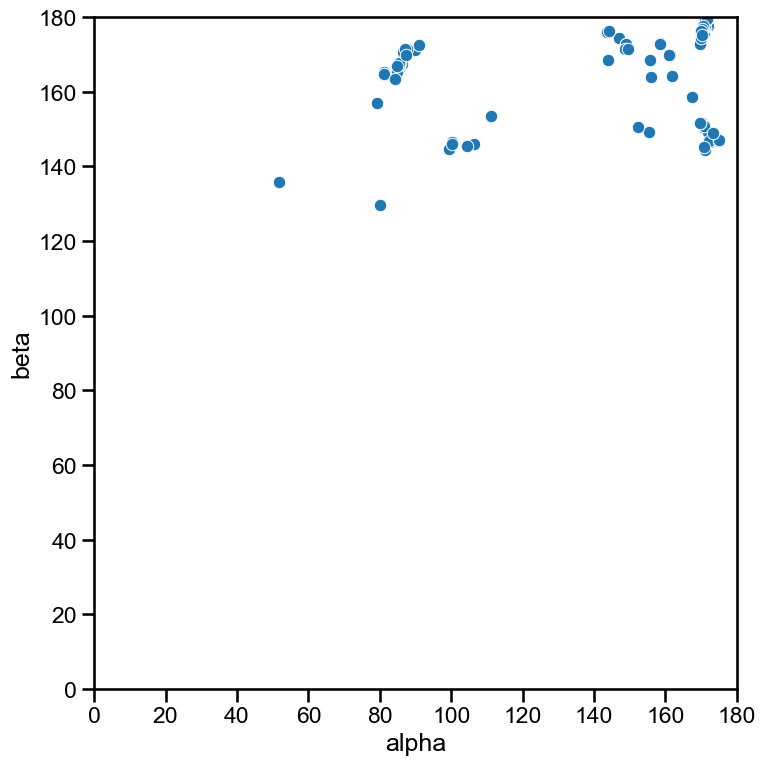

In [44]:
sns.set_context("talk")
#sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

Zoomed in

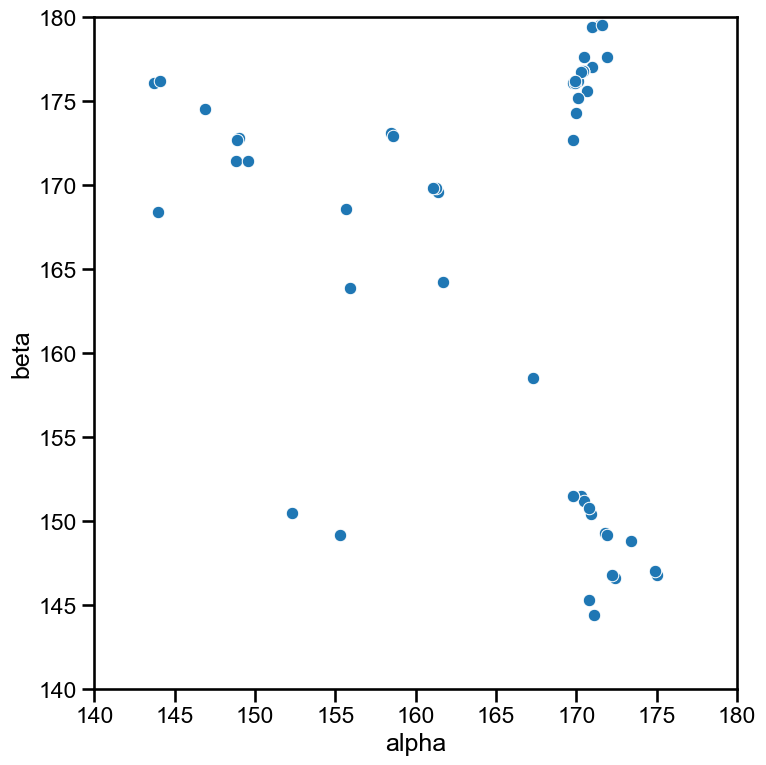

In [45]:
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

Hue by energy

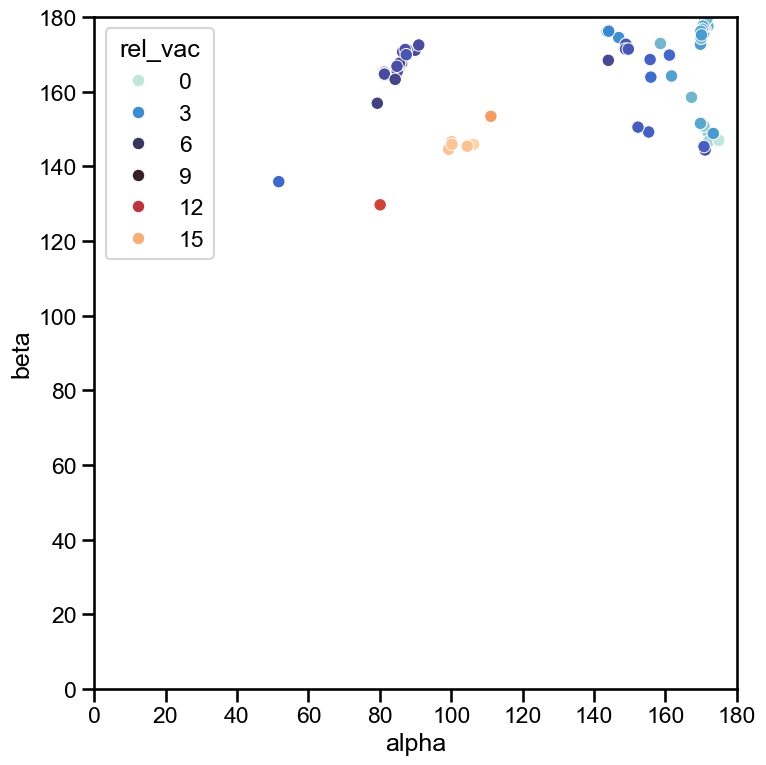

In [46]:
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='rel_vac', palette='icefire')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

Same plot, in better quality and with a color scale

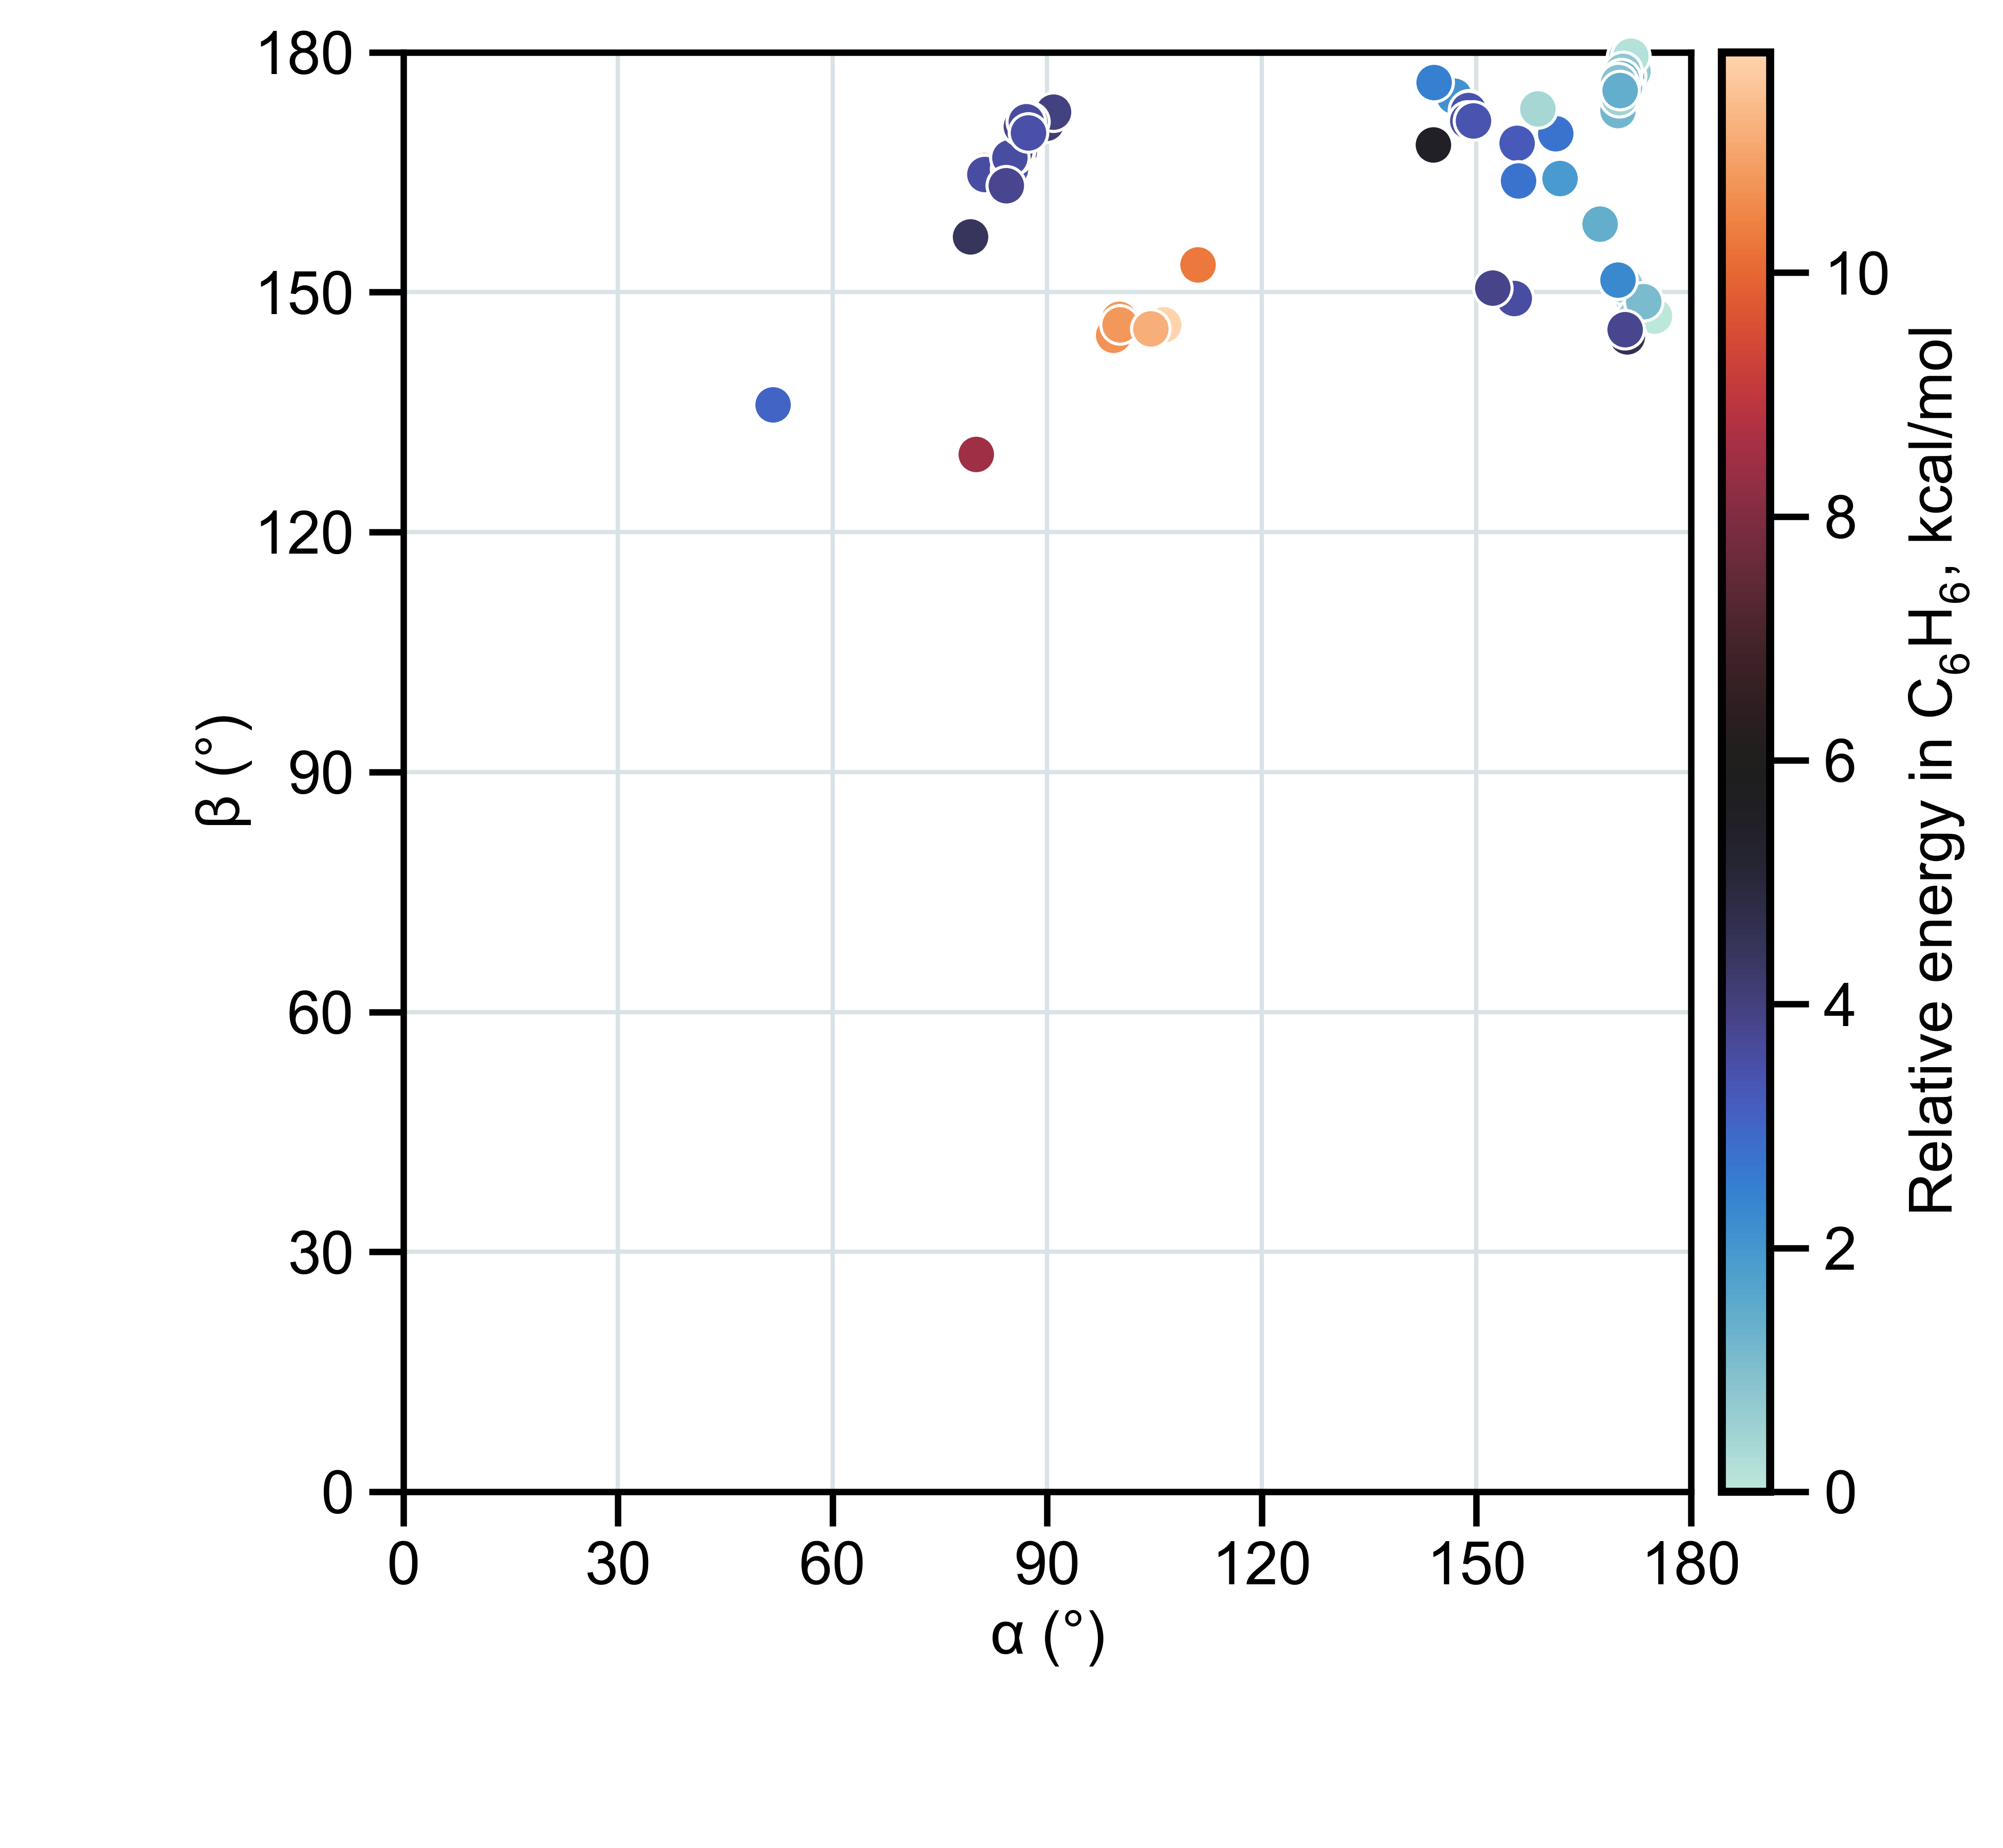

In [47]:

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.fontset"] = 'custom'
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.bf"] = 'sans:bold'
plt.rcParams["mathtext.rm"] = 'serif'
fonts = {'fontsize': 14}

fig, ax = plt.subplots(figsize=(6.5, 6), dpi=600)
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='rel_benzene', palette='icefire', zorder=5, clip_on=False)
ax.set_axisbelow(True)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.grid(visible=True, which='major', axis='both', lw=1, c='#d9e2e6')

ax.set_xticks([0, 30, 60, 90, 120, 150, 180])
ax.set_yticks([0, 30, 60, 90, 120, 150, 180])

plt.tick_params(direction='out', length=8, color='black', width=1.5, labelsize=14)
plt.xlim(0, 180)
plt.ylim(0, 180)


plt.xlabel(r'$\alpha$ (°)', **fonts, labelpad=3)
plt.ylabel(r'$\beta$ (°)', **fonts, labelpad=0.15)

ax.legend(**fonts, loc='best', title='Relative energy', title_fontsize=14)


norm = plt.Normalize(0, inp_out['rel_benzene'].max())
sm = plt.cm.ScalarMappable(cmap="icefire", norm=norm)
cbar=ax.figure.colorbar(sm, ax=ax, location='right', orientation='vertical', aspect=30, pad=.02)
cbar.ax.tick_params(labelsize=14, width=1.5)
cbar.set_label(label='Relative energy in C$_{6}$H$_{6}$, kcal/mol', size=14)



ax.get_legend().remove()

plt.tight_layout()

#plt.savefig('iPr_dft_energy_hue.svg', dpi='figure', format='svg', bbox_inches='tight')
plt.show()


Zoomed in. Green star is the best hit.

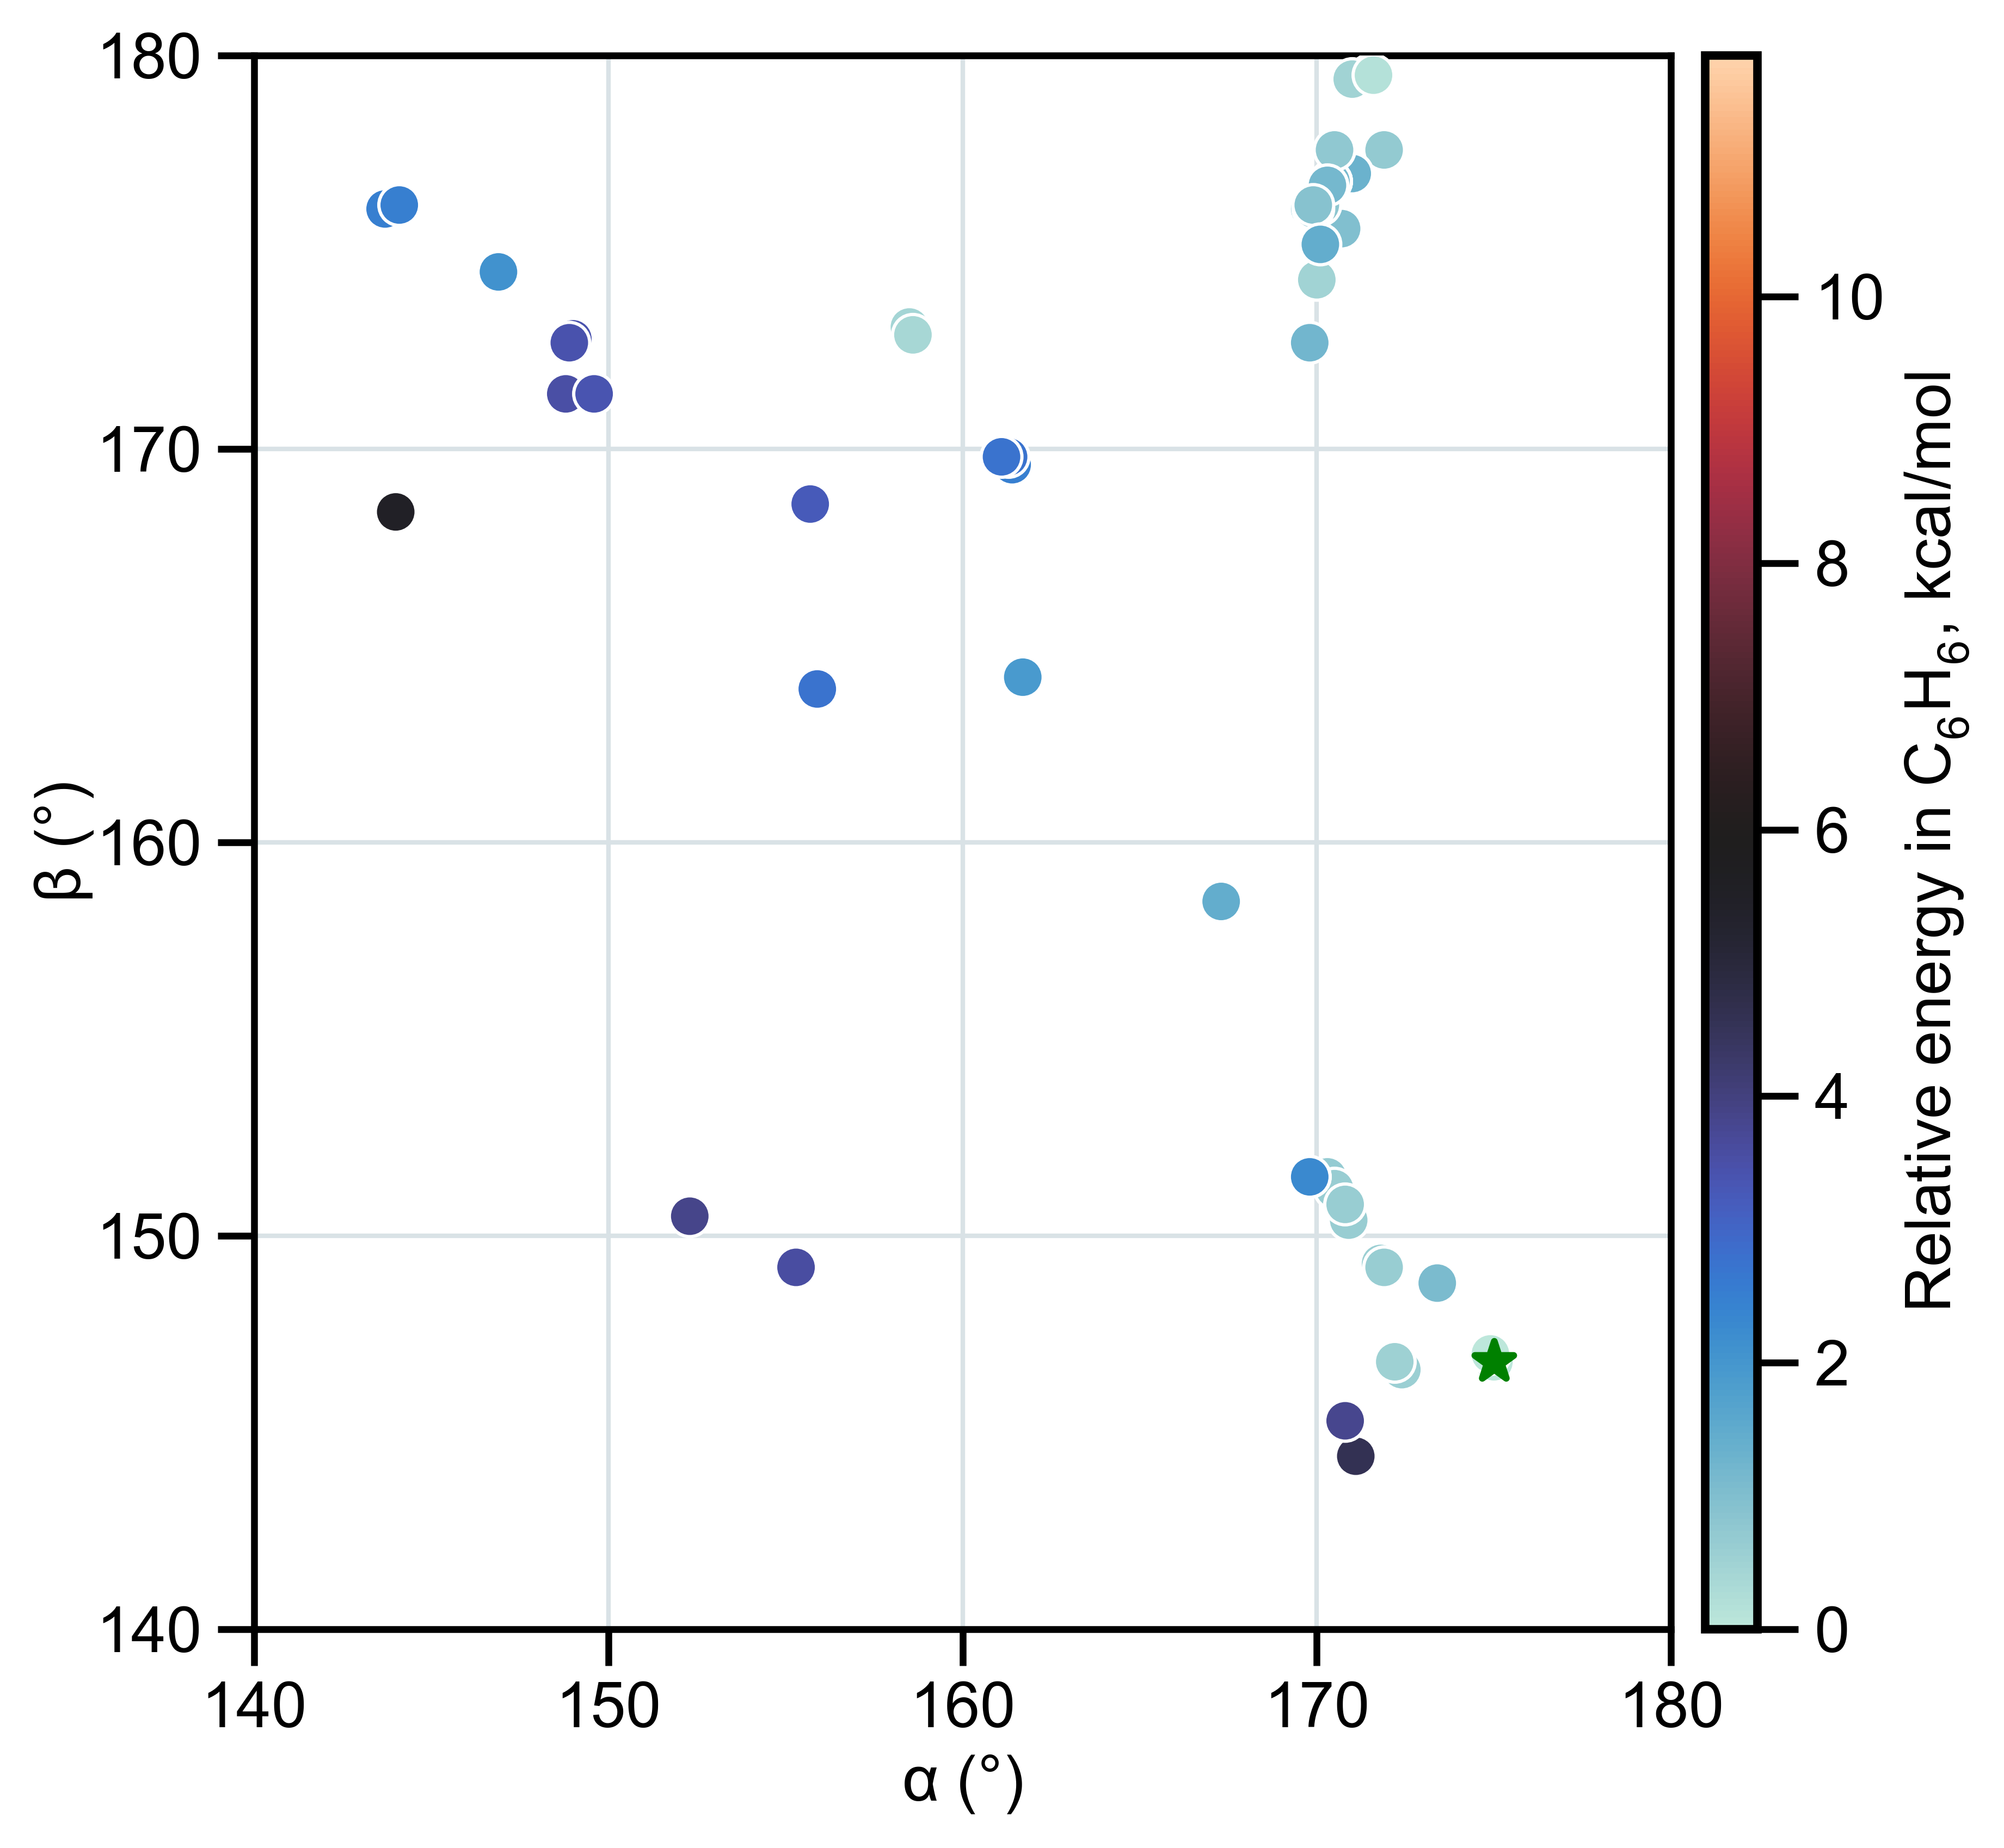

In [48]:

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.fontset"] = 'custom'
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.bf"] = 'sans:bold'
plt.rcParams["mathtext.rm"] = 'serif'
fonts = {'fontsize': 14}

fig, ax = plt.subplots(figsize=(6.5, 6), dpi=600)
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='rel_benzene', palette='icefire', zorder=5, clip_on=True)
plt.scatter(inp_out.iloc[25, 1], inp_out.iloc[25, 2], color='green', zorder=10, marker='*')

ax.set_axisbelow(True)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.grid(visible=True, which='major', axis='both', lw=1, c='#d9e2e6')

ax.set_xticks([140,150,160,170, 180])
ax.set_yticks([140,150,160,170, 180])

plt.tick_params(direction='out', length=8, color='black', width=1.5, labelsize=14)
plt.xlim(140, 180)
plt.ylim(140, 180)


plt.xlabel(r'$\alpha$ (°)', **fonts, labelpad=3)
plt.ylabel(r'$\beta$ (°)', **fonts, labelpad=0.15)

ax.legend(**fonts, loc='best', title='Relative energy', title_fontsize=14)


norm = plt.Normalize(0, inp_out['rel_benzene'].max())
sm = plt.cm.ScalarMappable(cmap="icefire", norm=norm)
cbar=ax.figure.colorbar(sm, ax=ax, location='right', orientation='vertical', aspect=30, pad=.02)
cbar.ax.tick_params(labelsize=14, width=1.5)
cbar.set_label(label='Relative energy in C$_{6}$H$_{6}$, kcal/mol', size=14)



ax.get_legend().remove()

plt.tight_layout()

#plt.savefig('iPr_dft_energy_hue_zoomed.svg', dpi='figure', format='svg', bbox_inches='tight')
plt.show()


# Some statistics on the output data

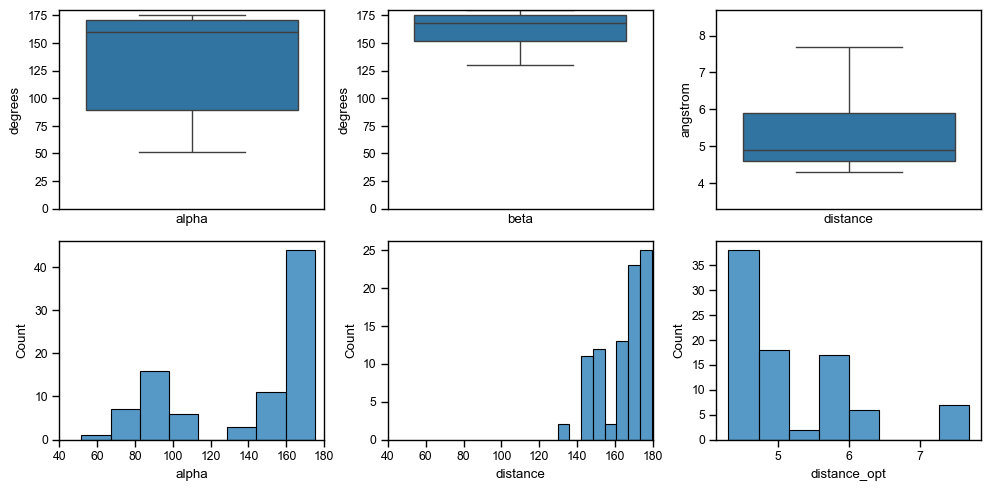

In [49]:
sns.set_context("paper")
#sns.set_style("white", {"axes.edgecolor": "black"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
axs = axs.flatten()

sns.boxplot(inp_out['alpha_opt'], ax=axs[0])
ax=axs[0]
ax.set_ylabel('degrees')
ax.set_xlabel('alpha')
ax.set_ylim([0,180])
ax.set_xticks([])

sns.boxplot(inp_out['beta_opt'], ax=axs[1])
ax=axs[1]
ax.set_ylabel('degrees')
ax.set_ylim([0,180])
ax.set_xlabel('beta')
ax.set_xticks([])

sns.boxplot(inp_out['distance_opt'], ax=axs[2])
ax=axs[2]
ax.set_ylabel('angstrom')
ax.set_ylim([inp_out['distance_opt'].min()-1, inp_out['distance_opt'].max()+1])
ax.set_xlabel('distance')
ax.set_xticks([])

sns.histplot(inp_out['alpha_opt'], ax=axs[3])
ax=axs[3]
ax.set_xlim([40,180])
ax.set_xlabel('alpha')

sns.histplot(inp_out['beta_opt'], ax=axs[4])
ax=axs[4]
ax.set_xlim([40,180])
ax.set_xlabel('beta')

sns.histplot(inp_out['distance_opt'], ax=axs[5])
ax.set_xlabel('distance')
plt.tight_layout()
plt.show()

# Clustering of output data

In [50]:
warnings.filterwarnings('ignore')
inertias = []
for i in range(1,11): # more than 10 clusters make no sense for 93 samples
    model = KMeans(n_clusters=i, random_state=123, max_iter=1000)
    model.fit(inp_out[['alpha_opt', 'beta_opt']])
    inertias.append(model.inertia_)

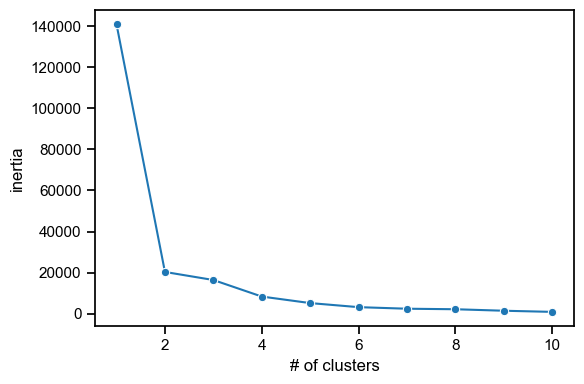

In [51]:
sns.set_context("notebook")
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=range(1,11), y=inertias, markers=True, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('inertia')
plt.tight_layout()
plt.show()

In [52]:
model = KMeans(n_clusters=4, random_state=123, max_iter=1000)
model.fit(inp_out[['alpha_opt', 'beta_opt']])
inp_out['cluster_opt'] = model.labels_

Data points by cluster, publication quality

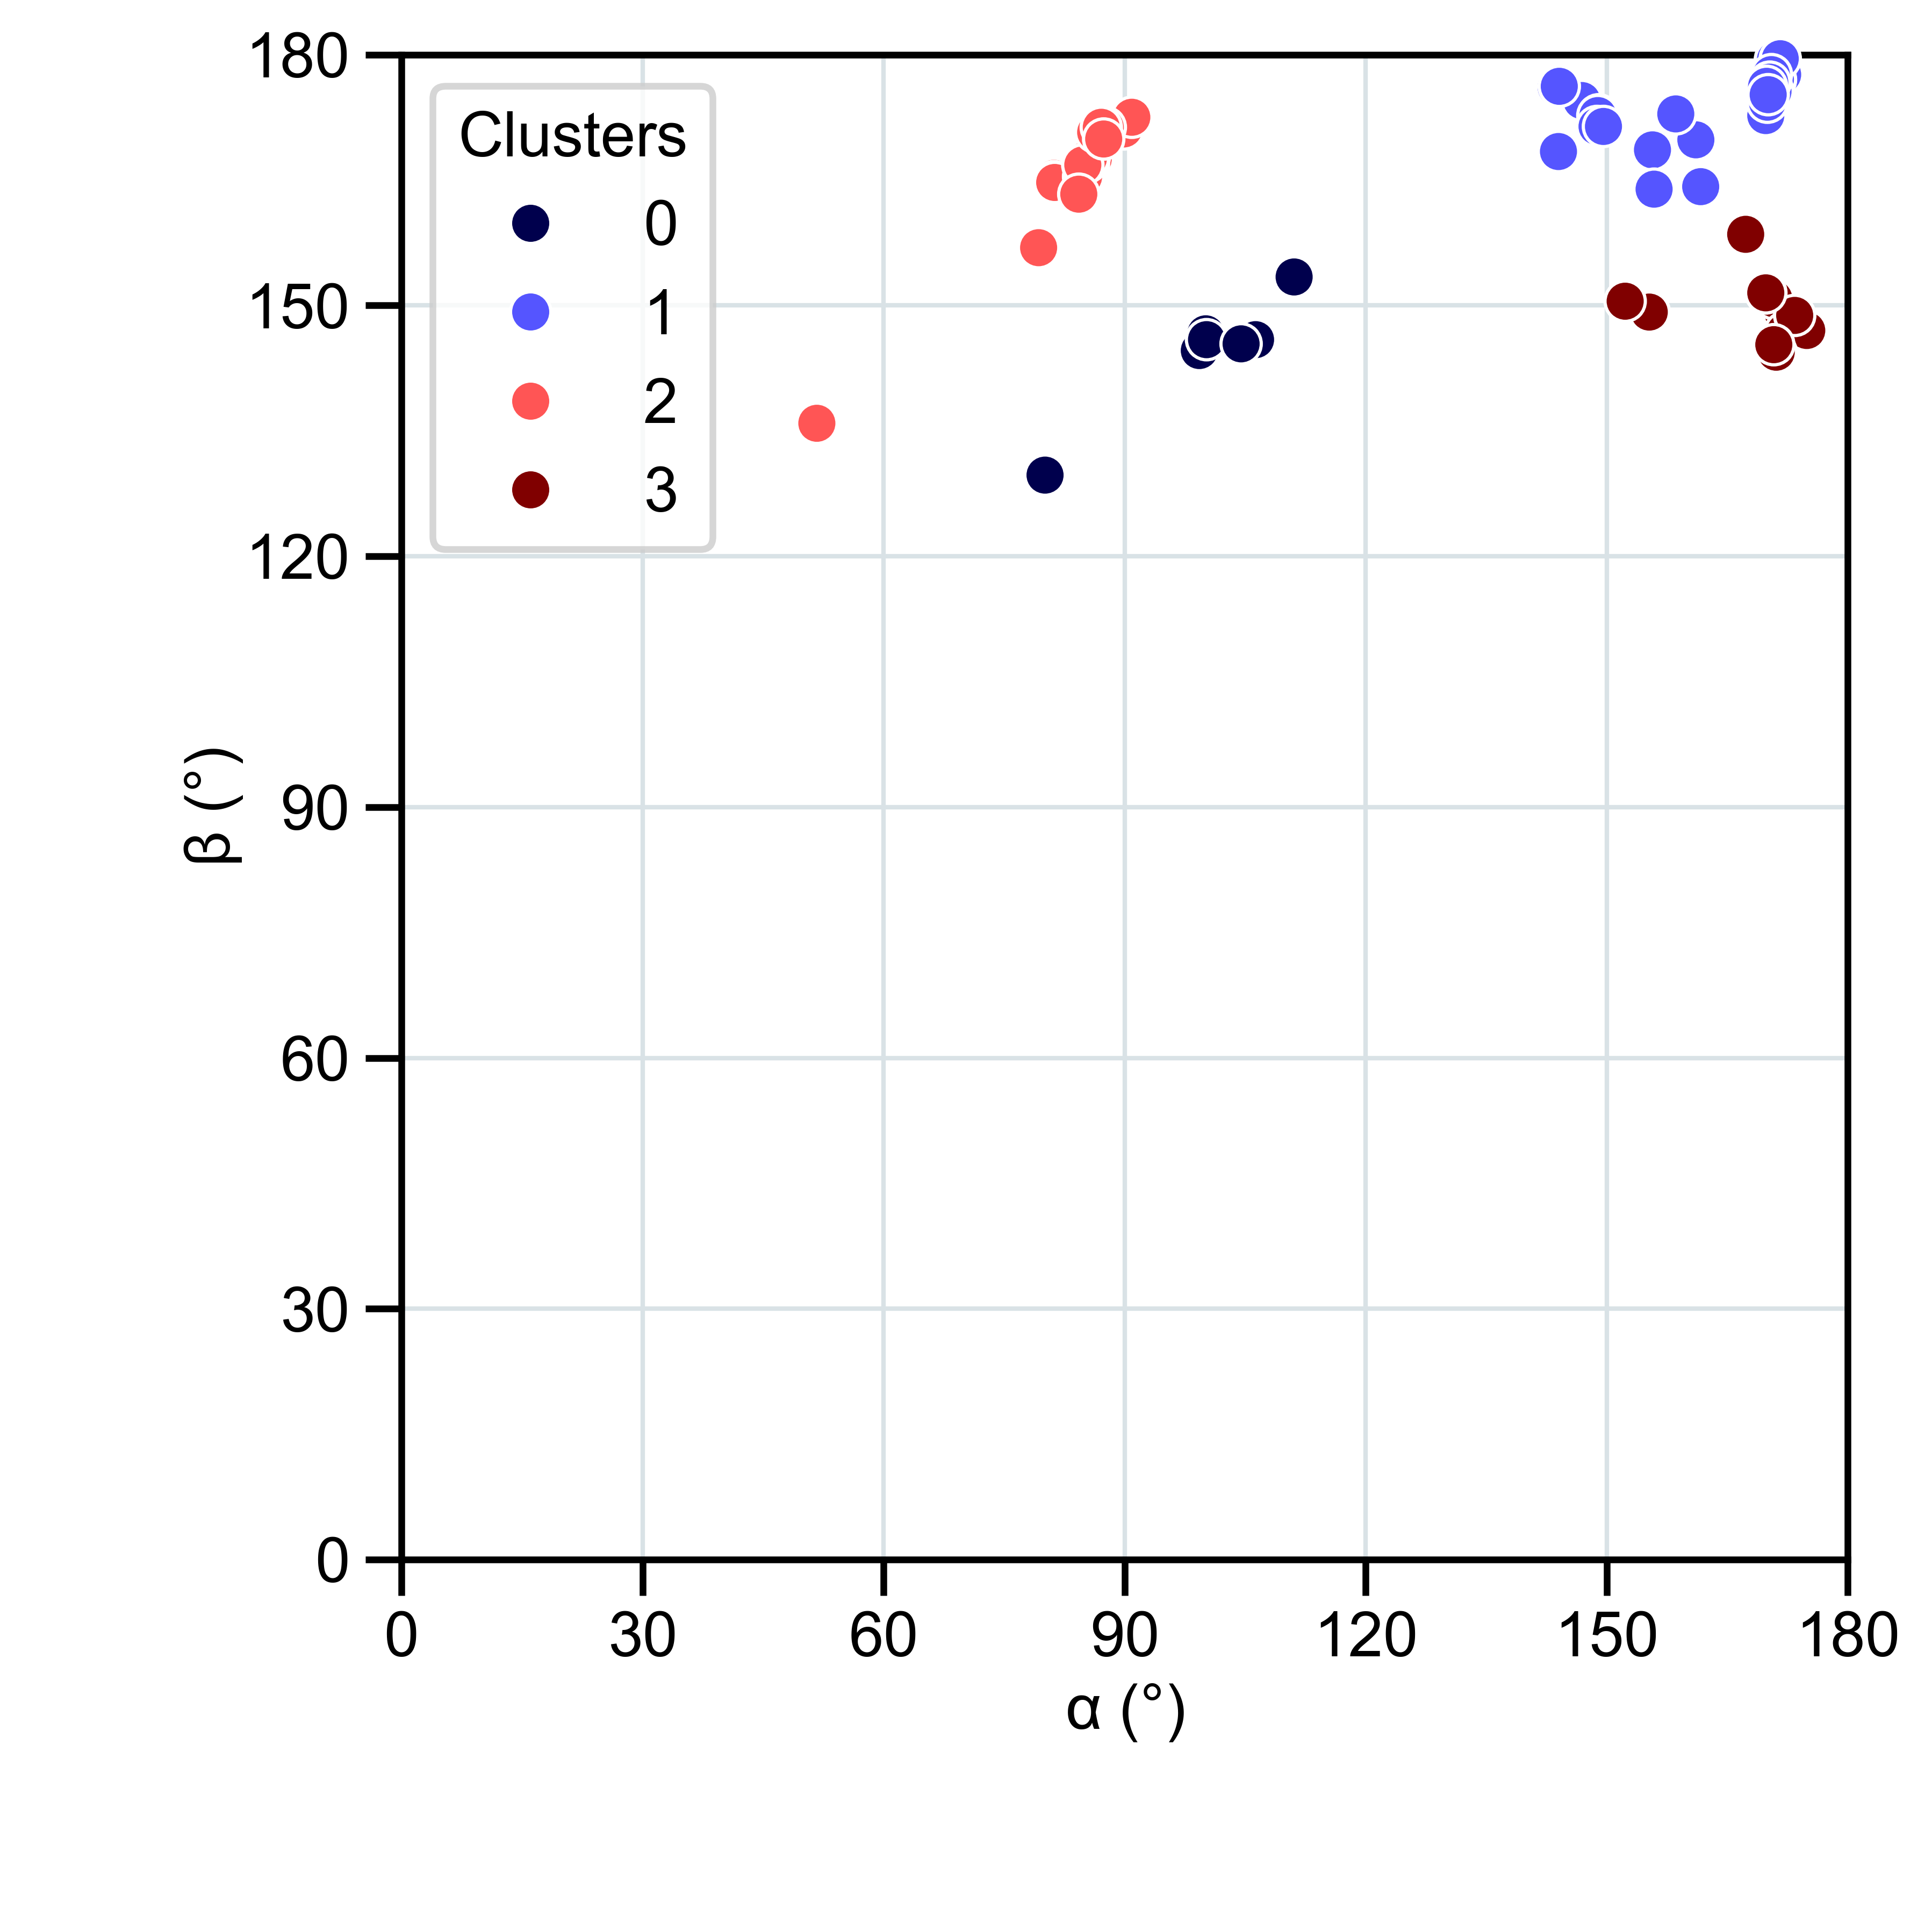

In [53]:
sns.set_context("talk")


plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.fontset"] = 'custom'
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.bf"] = 'sans:bold'
plt.rcParams["mathtext.rm"] = 'serif'
fonts = {'fontsize': 14}

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='cluster_opt', palette='seismic', zorder=5, clip_on=False)
ax.set_axisbelow(True)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.grid(visible=True, which='major', axis='both', lw=1, c='#d9e2e6')

ax.set_xticks([0, 30, 60, 90, 120, 150, 180])
ax.set_yticks([0, 30, 60, 90, 120, 150, 180])

plt.tick_params(direction='out', length=8, color='black', width=1.5, labelsize=14)
plt.xlim(0, 180)
plt.ylim(0, 180)


plt.xlabel(r'$\alpha$ (°)', **fonts, labelpad=3)
plt.ylabel(r'$\beta$ (°)', **fonts, labelpad=0.15)

ax.legend(**fonts, loc='best', title='Clusters', title_fontsize=14)


plt.tight_layout()

#plt.savefig('iPr_dft.svg', dpi='figure', format='svg', bbox_inches='tight')
plt.show()


# Comparison of input and optimized data
## Just for curiosity, disregard this part

In [54]:
geometry = inp_out[['name', 'alpha_inp', 'beta_inp', 'alpha_opt', 'beta_opt', 'rel_benzene', 'rel_energy_inp_kcal', 'cluster_inp']]

In [55]:
geometry['dA'] = geometry['alpha_opt'] - geometry['alpha_inp']
geometry['dB'] = geometry['beta_opt'] - geometry['beta_inp']
geometry['dE'] = geometry['rel_benzene'] - geometry['rel_energy_inp_kcal']

In [56]:
geometry.sort_values('rel_benzene').head(10)

,name,alpha_inp,beta_inp,alpha_opt,beta_opt,rel_benzene,rel_energy_inp_kcal,cluster_inp,dA,dB,dE
25,structure_32,170.9,157.6,175.0,146.8,0.000000,3.905622,1,4.1,-10.8,-3.905622
26,structure_33,169.4,159.9,174.9,147.0,0.040161,3.926167,1,5.5,-12.9,-3.886006
3,structure_12,175.1,177.7,171.5,179.5,0.128012,0.933853,1,-3.6,1.8,-0.805841
49,structure_55,161.0,175.8,171.6,179.5,0.147465,5.321841,1,10.6,3.7,-5.174376
4,structure_13,172.6,177.7,171.5,179.5,0.259789,0.977057,1,-1.1,1.8,-0.717268
77,structure_82,145.0,149.6,158.6,172.9,0.404743,10.988793,3,13.6,23.3,-10.584050
66,structure_71,151.1,159.3,158.5,173.1,0.449924,8.594526,3,7.4,13.8,-8.144602
8,structure_17,176.0,178.3,171.0,179.4,0.468749,1.711092,1,-5.0,1.1,-1.242342
43,structure_5,176.6,179.4,170.0,174.3,0.496987,0.388930,1,-6.6,-5.1,0.108057
24,structure_31,174.4,147.0,172.2,146.8,0.549070,3.601557,1,-2.2,-0.2,-3.052486


In [57]:
geometry[geometry['dA'] == geometry['dA'].min()]

,name,alpha_inp,beta_inp,alpha_opt,beta_opt,rel_benzene,rel_energy_inp_kcal,cluster_inp,dA,dB,dE
82,structure_89,121.1,165.6,87.1,171.3,3.600647,12.659266,0,-34.0,5.7,-9.05862


In [58]:
inp_out[inp_out['alpha_opt']<100].sort_values('association_vacuum').head(10)

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
72,structure_78,51.7,135.9,5.8,-4651.819402,2.048746,-4649.770656,-4651.843012,-4651.867388,-4651.877851,...,126.2,6.5,-311.146079,9.316507,2,3.969622,3.032123,3.068519,3.062244,2
86,structure_92,87.4,169.9,5.9,-4651.815597,2.045806,-4649.769791,-4651.839376,-4651.863327,-4651.873372,...,142.2,7.7,-311.138670,13.965627,0,4.512417,3.468870,3.771957,4.027980,2
75,structure_80,87.6,171.3,5.9,-4651.815412,2.045836,-4649.769576,-4651.839290,-4651.863447,-4651.873616,...,162.9,6.4,-311.145807,9.487233,2,4.647332,3.541661,3.715481,3.893693,2
47,structure_53,84.9,165.4,5.9,-4651.815570,2.046058,-4649.769512,-4651.839747,-4651.864230,-4651.874539,...,169.9,6.3,-311.152738,5.137711,2,4.687492,3.394196,3.363448,3.453810,2
57,structure_62,84.8,166.8,5.9,-4651.815365,2.045865,-4649.769500,-4651.839292,-4651.863514,-4651.873705,...,170.9,6.3,-311.150435,6.583021,2,4.695022,3.558604,3.691635,3.856043,2
82,structure_89,87.1,171.3,5.9,-4651.815300,2.045817,-4649.769483,-4651.839177,-4651.863341,-4651.873519,...,165.6,6.3,-311.140752,12.659266,0,4.705690,3.600647,3.770074,3.942639,2
30,structure_38,90.9,172.5,5.7,-4651.815609,2.046252,-4649.769357,-4651.838982,-4651.862395,-4651.872175,...,173.0,6.3,-311.153427,4.705201,2,4.784756,3.995977,4.636664,5.058978,2
45,structure_51,81.2,164.8,6.0,-4651.815249,2.046047,-4649.769202,-4651.839436,-4651.863936,-4651.874255,...,164.8,6.4,-311.152887,5.044476,2,4.882020,3.582449,3.541033,3.625119,2
46,structure_52,81.3,164.7,6.0,-4651.815196,2.046012,-4649.769184,-4651.839377,-4651.863868,-4651.874183,...,165.2,6.4,-311.152796,5.101033,2,4.893315,3.597509,3.561741,3.648337,2
28,structure_36,89.9,171.1,5.7,-4651.816315,2.047163,-4649.769152,-4651.839607,-4651.862971,-4651.872744,...,171.7,6.3,-311.153679,4.547263,2,4.913395,4.175445,4.846880,5.273586,2


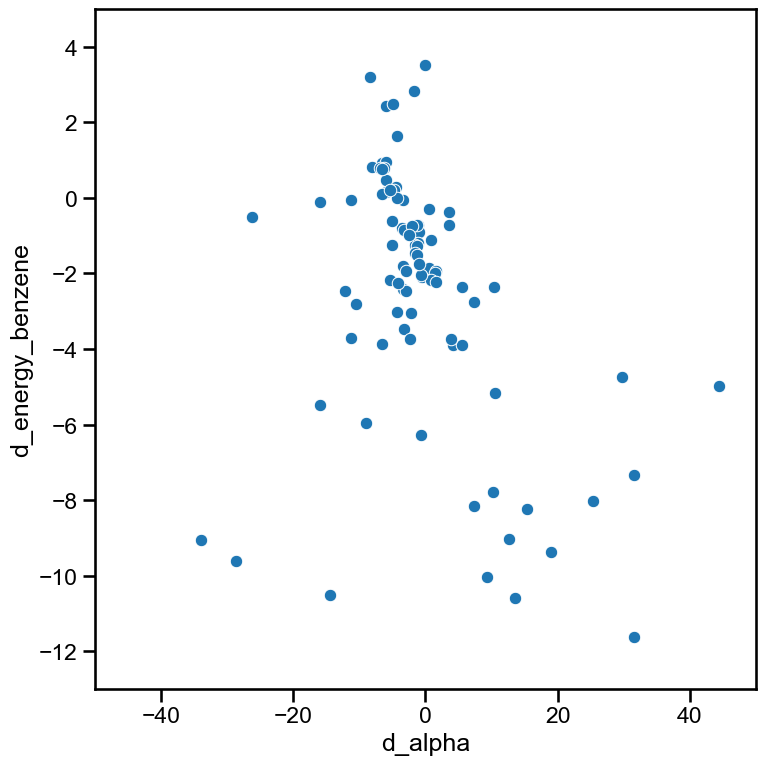

In [59]:
sns.set_context("talk")

fig = plt.figure()
sns.scatterplot(data=geometry, x='dA', y='dE')
plt.xlim([-50, 50])
plt.ylim([-13, 5])

plt.xlabel('d_alpha')
plt.ylabel('d_energy_benzene')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

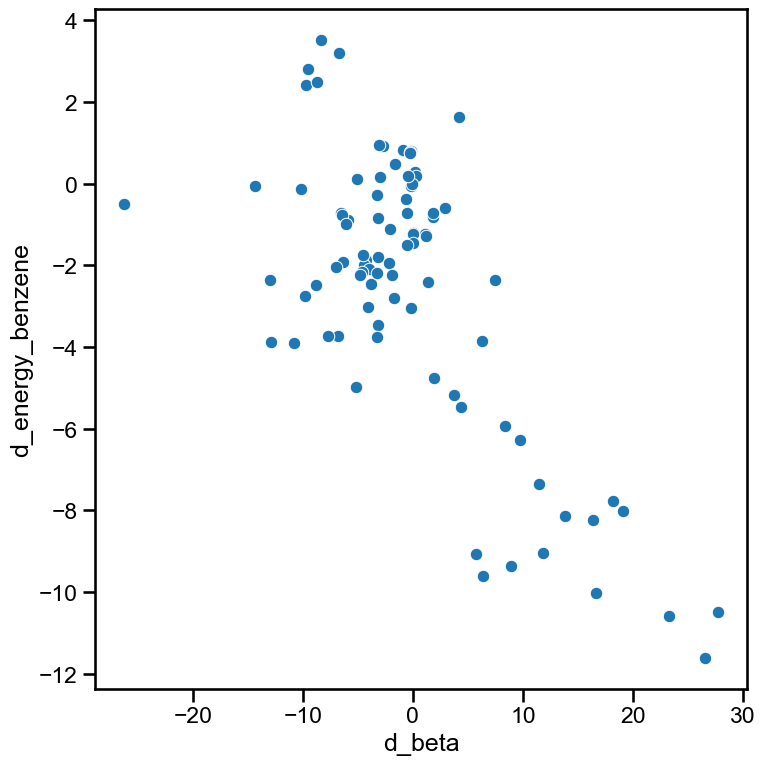

In [60]:
fig = plt.figure()
sns.scatterplot(data=geometry, x='dB', y='dE')
# plt.xlim([-50, 50])
# plt.ylim([-13, 5])

plt.xlabel('d_beta')
plt.ylabel('d_energy_benzene')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

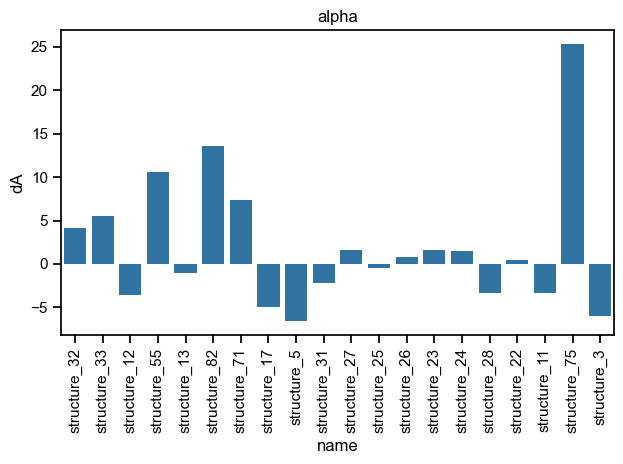

In [61]:
sns.set_context("notebook")
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[0:20], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

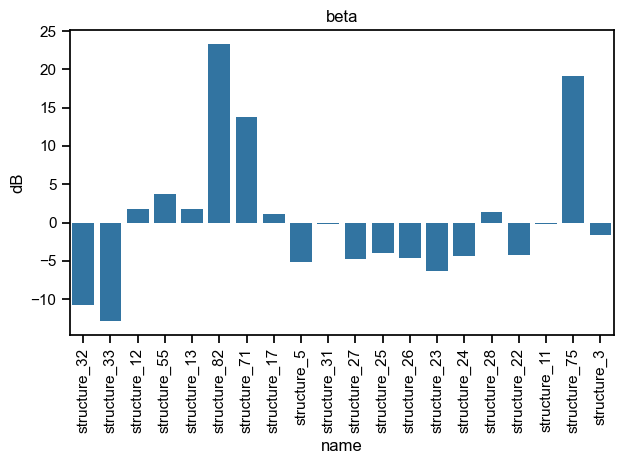

In [62]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[0:20], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

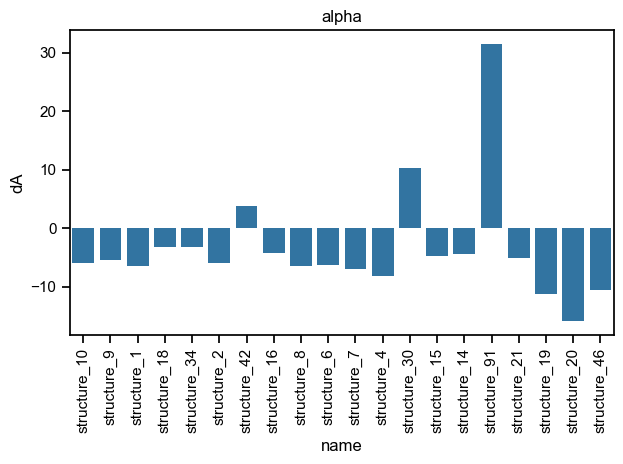

In [63]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[20:40], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

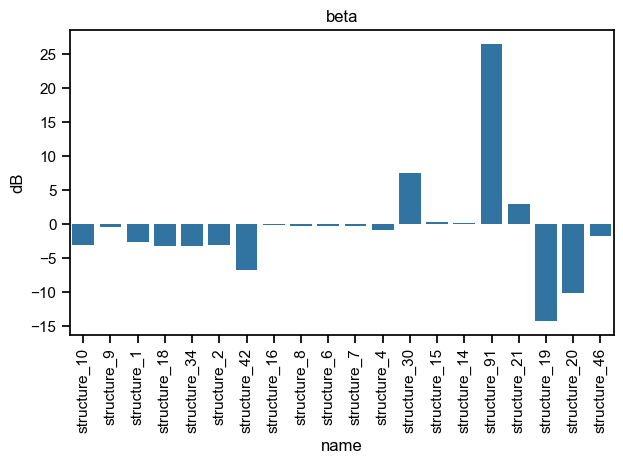

In [64]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[20:40], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

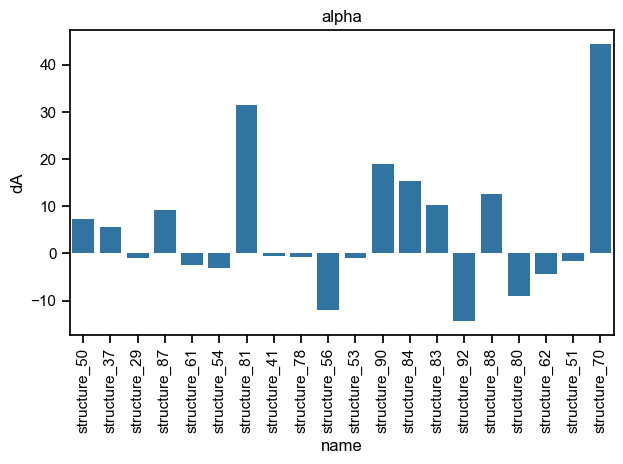

In [65]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[40:60], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

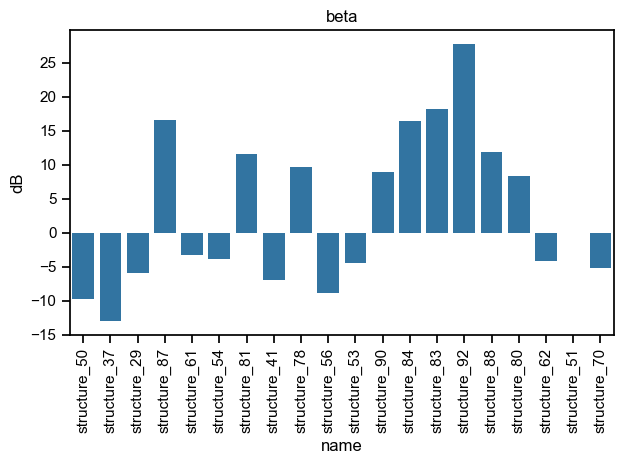

In [66]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[40:60], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

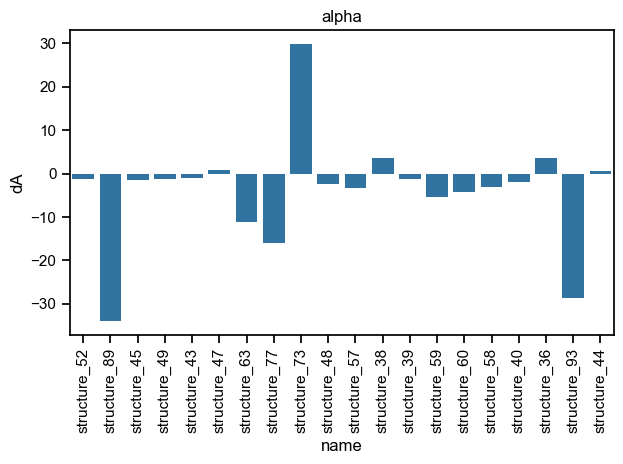

In [67]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[60:80], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

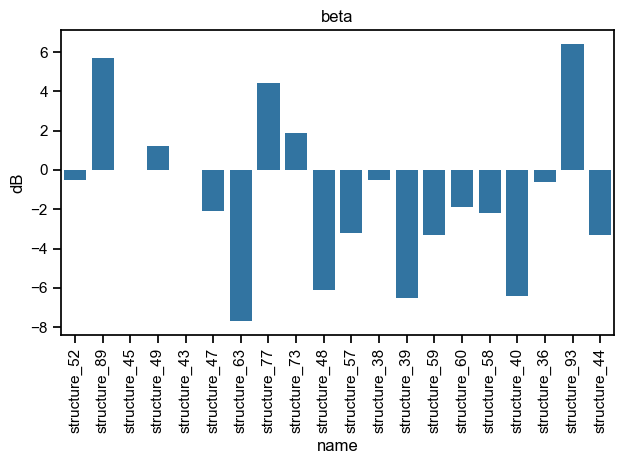

In [68]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[60:80], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

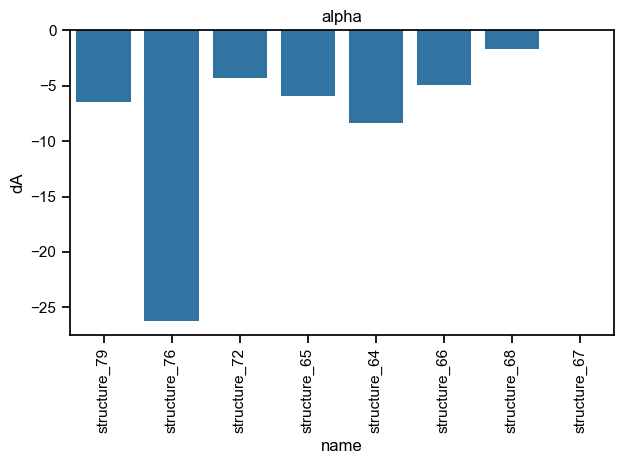

In [69]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[80:], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

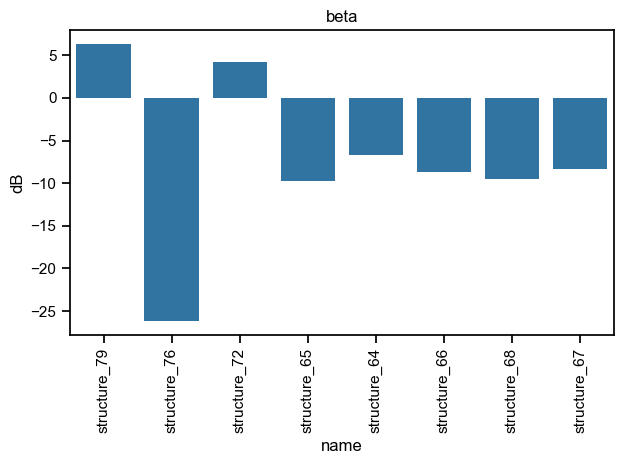

In [70]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[80:], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

# Removing duplicates from output by crest

The `ensemble.xyz` is generated, which is similar to the output from the xtb docking procedure.
It uses SPE (R2SCAN-3c) energy in vacuum for the energy sorting.
Look at `opt_structures_to-crest.ipynb` for the code.

After successful CREST run, the new sorted ensemble is renamed to `crest_ensemble_orca.xyz` and copied in the current folder.

In [71]:
df = pd.read_csv('crest_ensemble_orca.xyz')

In [72]:
# energy values

df_e = df[df.index % n_rows == 0].astype('float64')

In [73]:
final_df = inp_out.sort_values(by='SPE_vac').reset_index(drop=True)

In [74]:
df_e.columns = df_e.columns.str.strip()
df_e = df_e.rename(columns={f'{atoms}':'SPE_vac'})
final_df = final_df.merge(df_e, on='SPE_vac')

In [75]:
final_df

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
0,structure_32,175.0,146.8,4.9,-4651.823922,2.046940,-4649.776982,-4651.846038,-4651.868306,-4651.877649,...,157.6,4.8,-311.154701,3.905622,1,0.000000,0.000000,1.359184,2.055719,3
1,structure_37,169.8,151.5,4.9,-4651.822600,2.049079,-4649.773521,-4651.844518,-4651.866693,-4651.876039,...,164.5,4.7,-311.153497,4.661281,1,2.171809,2.296055,3.713598,4.408251,3
2,structure_27,172.4,146.6,4.9,-4651.822523,2.046478,-4649.776045,-4651.844645,-4651.866843,-4651.876125,...,151.4,4.7,-311.156440,2.814623,1,0.587976,0.584211,1.987321,2.722134,3
3,structure_22,170.3,151.5,4.8,-4651.822233,2.046635,-4649.775598,-4651.844693,-4651.867332,-4651.876843,...,155.8,4.8,-311.156918,2.514542,1,0.868472,0.652609,1.778988,2.370101,3
4,structure_25,171.8,149.3,4.9,-4651.822095,2.046465,-4649.775630,-4651.844609,-4651.867260,-4651.876757,...,153.3,4.8,-311.156625,2.698414,1,0.848392,0.598644,1.717492,2.317391,3
5,structure_21,167.3,158.5,4.8,-4651.820789,2.046433,-4649.774356,-4651.843217,-4651.865854,-4651.875379,...,155.6,4.8,-311.157655,2.052086,1,1.647839,1.452056,2.579689,3.162018,3
6,structure_5,170.0,174.3,4.6,-4651.820501,2.046182,-4649.774319,-4651.844488,-4651.868841,-4651.879173,...,179.4,4.4,-311.160306,0.388930,1,1.671056,0.496987,0.547815,0.623744,1
7,structure_19,161.7,164.2,4.8,-4651.820484,2.047195,-4649.773289,-4651.843252,-4651.866056,-4651.875593,...,178.5,4.4,-311.157808,1.956353,1,2.317391,1.908255,2.931095,3.505893,1
8,structure_2,170.7,175.6,4.6,-4651.820032,2.046277,-4649.773755,-4651.843817,-4651.867925,-4651.878140,...,178.7,4.4,-311.160894,0.019810,1,2.024972,0.977659,1.182227,1.331574,1
9,structure_47,170.8,145.3,4.9,-4651.819799,2.049622,-4649.770177,-4651.842665,-4651.865883,-4651.875704,...,147.4,5.0,-311.153094,4.914312,1,4.270199,3.799567,4.562618,4.959204,3


The ensemble from crest had 47 structures, but here we see 48. It means that there were two structure with exactly the same SPE in the optimized dataset. We can locate and manualy delete this structure quite easily.

In [76]:
final_df['SPE_vac'].value_counts()

-4651.819243    2
-4651.823922    1
-4651.817545    1
-4651.816315    1
-4651.816169    1
-4651.815887    1
-4651.815773    1
-4651.815686    1
-4651.815609    1
-4651.815597    1
-4651.815412    1
-4651.815300    1
-4651.815249    1
-4651.814949    1
-4651.814808    1
-4651.814643    1
-4651.814551    1
-4651.814410    1
-4651.801196    1
-4651.797262    1
-4651.796848    1
-4651.796799    1
-4651.795875    1
-4651.817106    1
-4651.817643    1
-4651.822600    1
-4651.817815    1
-4651.822523    1
-4651.822233    1
-4651.822095    1
-4651.820789    1
-4651.820501    1
-4651.820484    1
-4651.820032    1
-4651.819799    1
-4651.819709    1
-4651.819596    1
-4651.819536    1
-4651.819493    1
-4651.819426    1
-4651.819402    1
-4651.818999    1
-4651.818753    1
-4651.818371    1
-4651.818206    1
-4651.817978    1
-4651.795708    1
Name: SPE_vac, dtype: int64

There are two structures with energy -4651.819243 eh. We can locate and delete one of them.

In [77]:
final_df[final_df['SPE_vac'] == -4651.819243]

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
16,structure_15,171.0,177.0,4.6,-4651.819243,2.045845,-4649.773398,-4651.842812,-4651.866741,-4651.876899,...,176.7,4.4,-311.159111,1.138565,1,2.248992,1.337222,1.654114,1.839229,1
17,structure_14,171.0,177.0,4.6,-4651.819243,2.045848,-4649.773395,-4651.842809,-4651.866735,-4651.876893,...,176.8,4.4,-311.159236,1.059888,1,2.250875,1.340987,1.659761,1.844876,1


Let's delete structure 15.

In [78]:
final_df = final_df[final_df['name'] != 'structure_15'].reset_index(drop=True)

# Plot of the final data

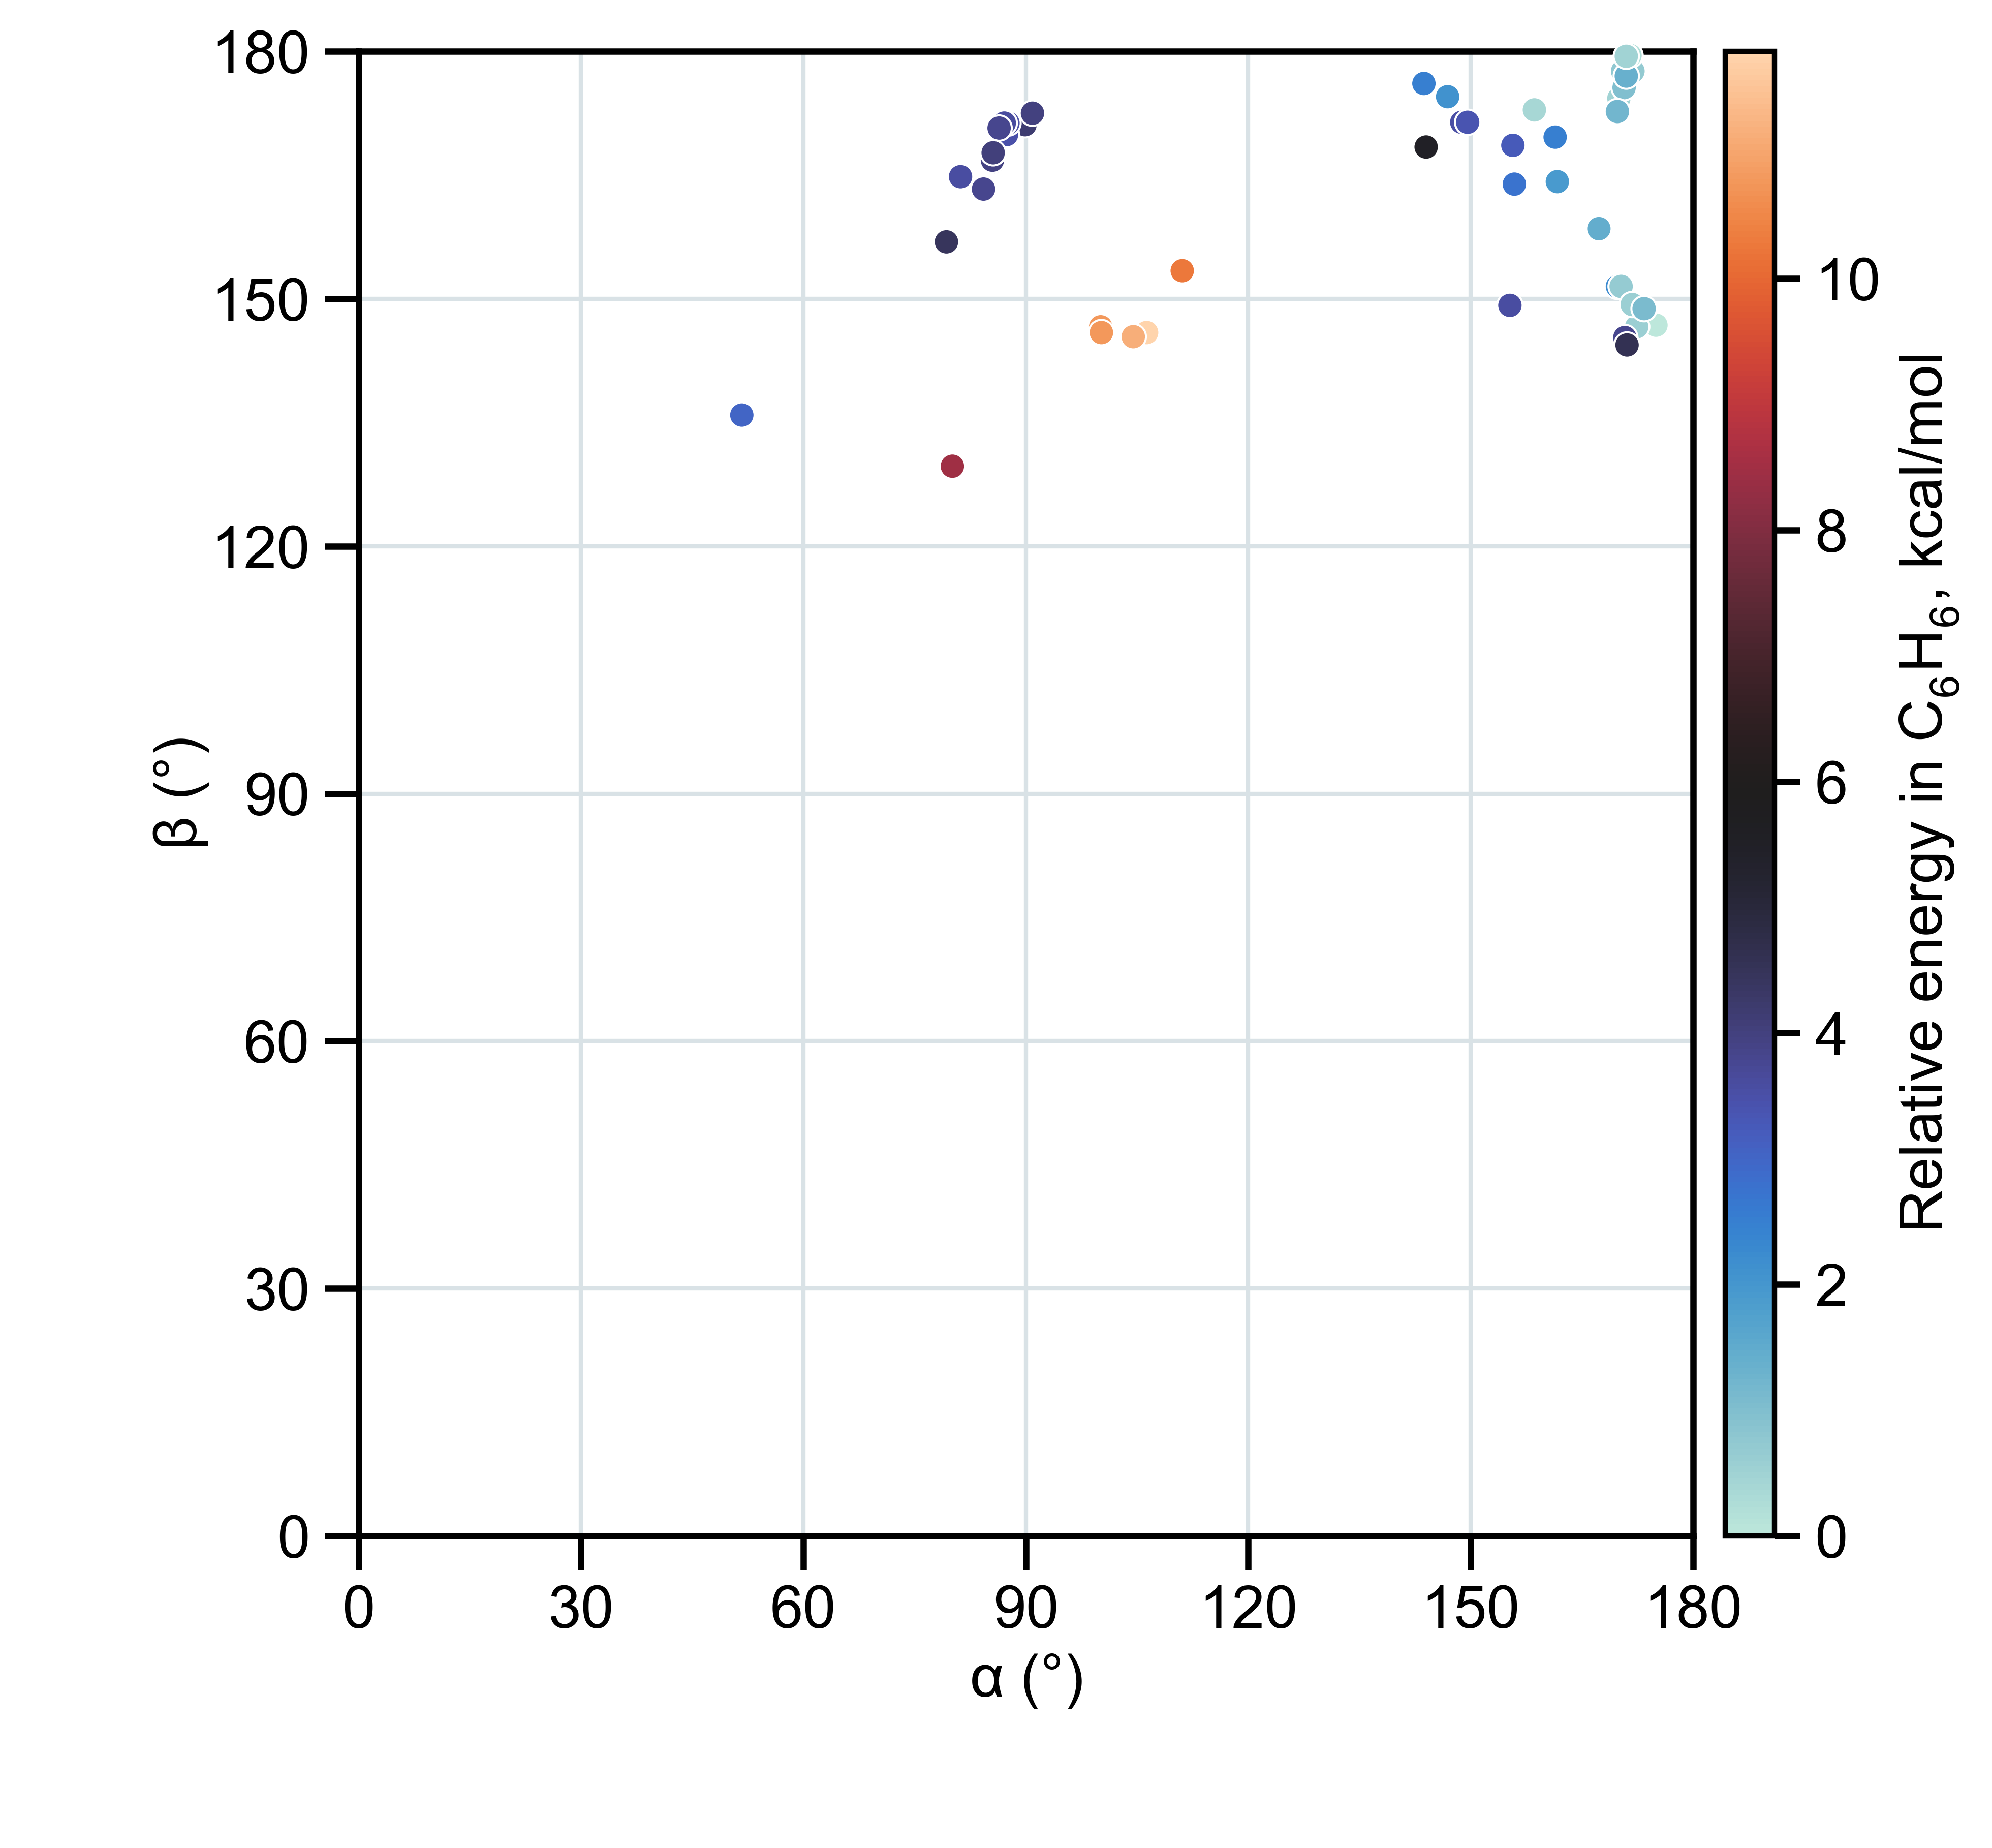

In [79]:

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.fontset"] = 'custom'
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.bf"] = 'sans:bold'
plt.rcParams["mathtext.rm"] = 'serif'
fonts = {'fontsize': 14}

fig, ax = plt.subplots(figsize=(6.5, 6), dpi=600)
sns.scatterplot(data=final_df, x='alpha_opt', y='beta_opt', hue='rel_benzene', palette='icefire', zorder=5, clip_on=False)
ax.set_axisbelow(True)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.grid(visible=True, which='major', axis='both', lw=1, c='#d9e2e6')

ax.set_xticks([0, 30, 60, 90, 120, 150, 180])
ax.set_yticks([0, 30, 60, 90, 120, 150, 180])

plt.tick_params(direction='out', length=8, color='black', width=1.5, labelsize=14)
plt.xlim(0, 180)
plt.ylim(0, 180)


plt.xlabel(r'$\alpha$ (°)', **fonts, labelpad=3)
plt.ylabel(r'$\beta$ (°)', **fonts, labelpad=0.15)

ax.legend(**fonts, loc='best', title='Relative energy', title_fontsize=14)


norm = plt.Normalize(0, inp_out['rel_benzene'].max())
sm = plt.cm.ScalarMappable(cmap="icefire", norm=norm)
cbar=ax.figure.colorbar(sm, ax=ax, location='right', orientation='vertical', aspect=30, pad=.02)
cbar.ax.tick_params(labelsize=14, width=1.5)
cbar.set_label(label='Relative energy in C$_{6}$H$_{6}$, kcal/mol', size=14)



ax.get_legend().remove()

plt.tight_layout()

#plt.savefig('iPr_dft_energy_hue_no_duplicates.svg', dpi='figure', format='svg', bbox_inches='tight')
plt.show()

In [80]:
final_df[final_df['rel_benzene']==0]

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
0,structure_32,175.0,146.8,4.9,-4651.823922,2.04694,-4649.776982,-4651.846038,-4651.868306,-4651.877649,...,157.6,4.8,-311.154701,3.905622,1,0.0,0.0,1.359184,2.055719,3


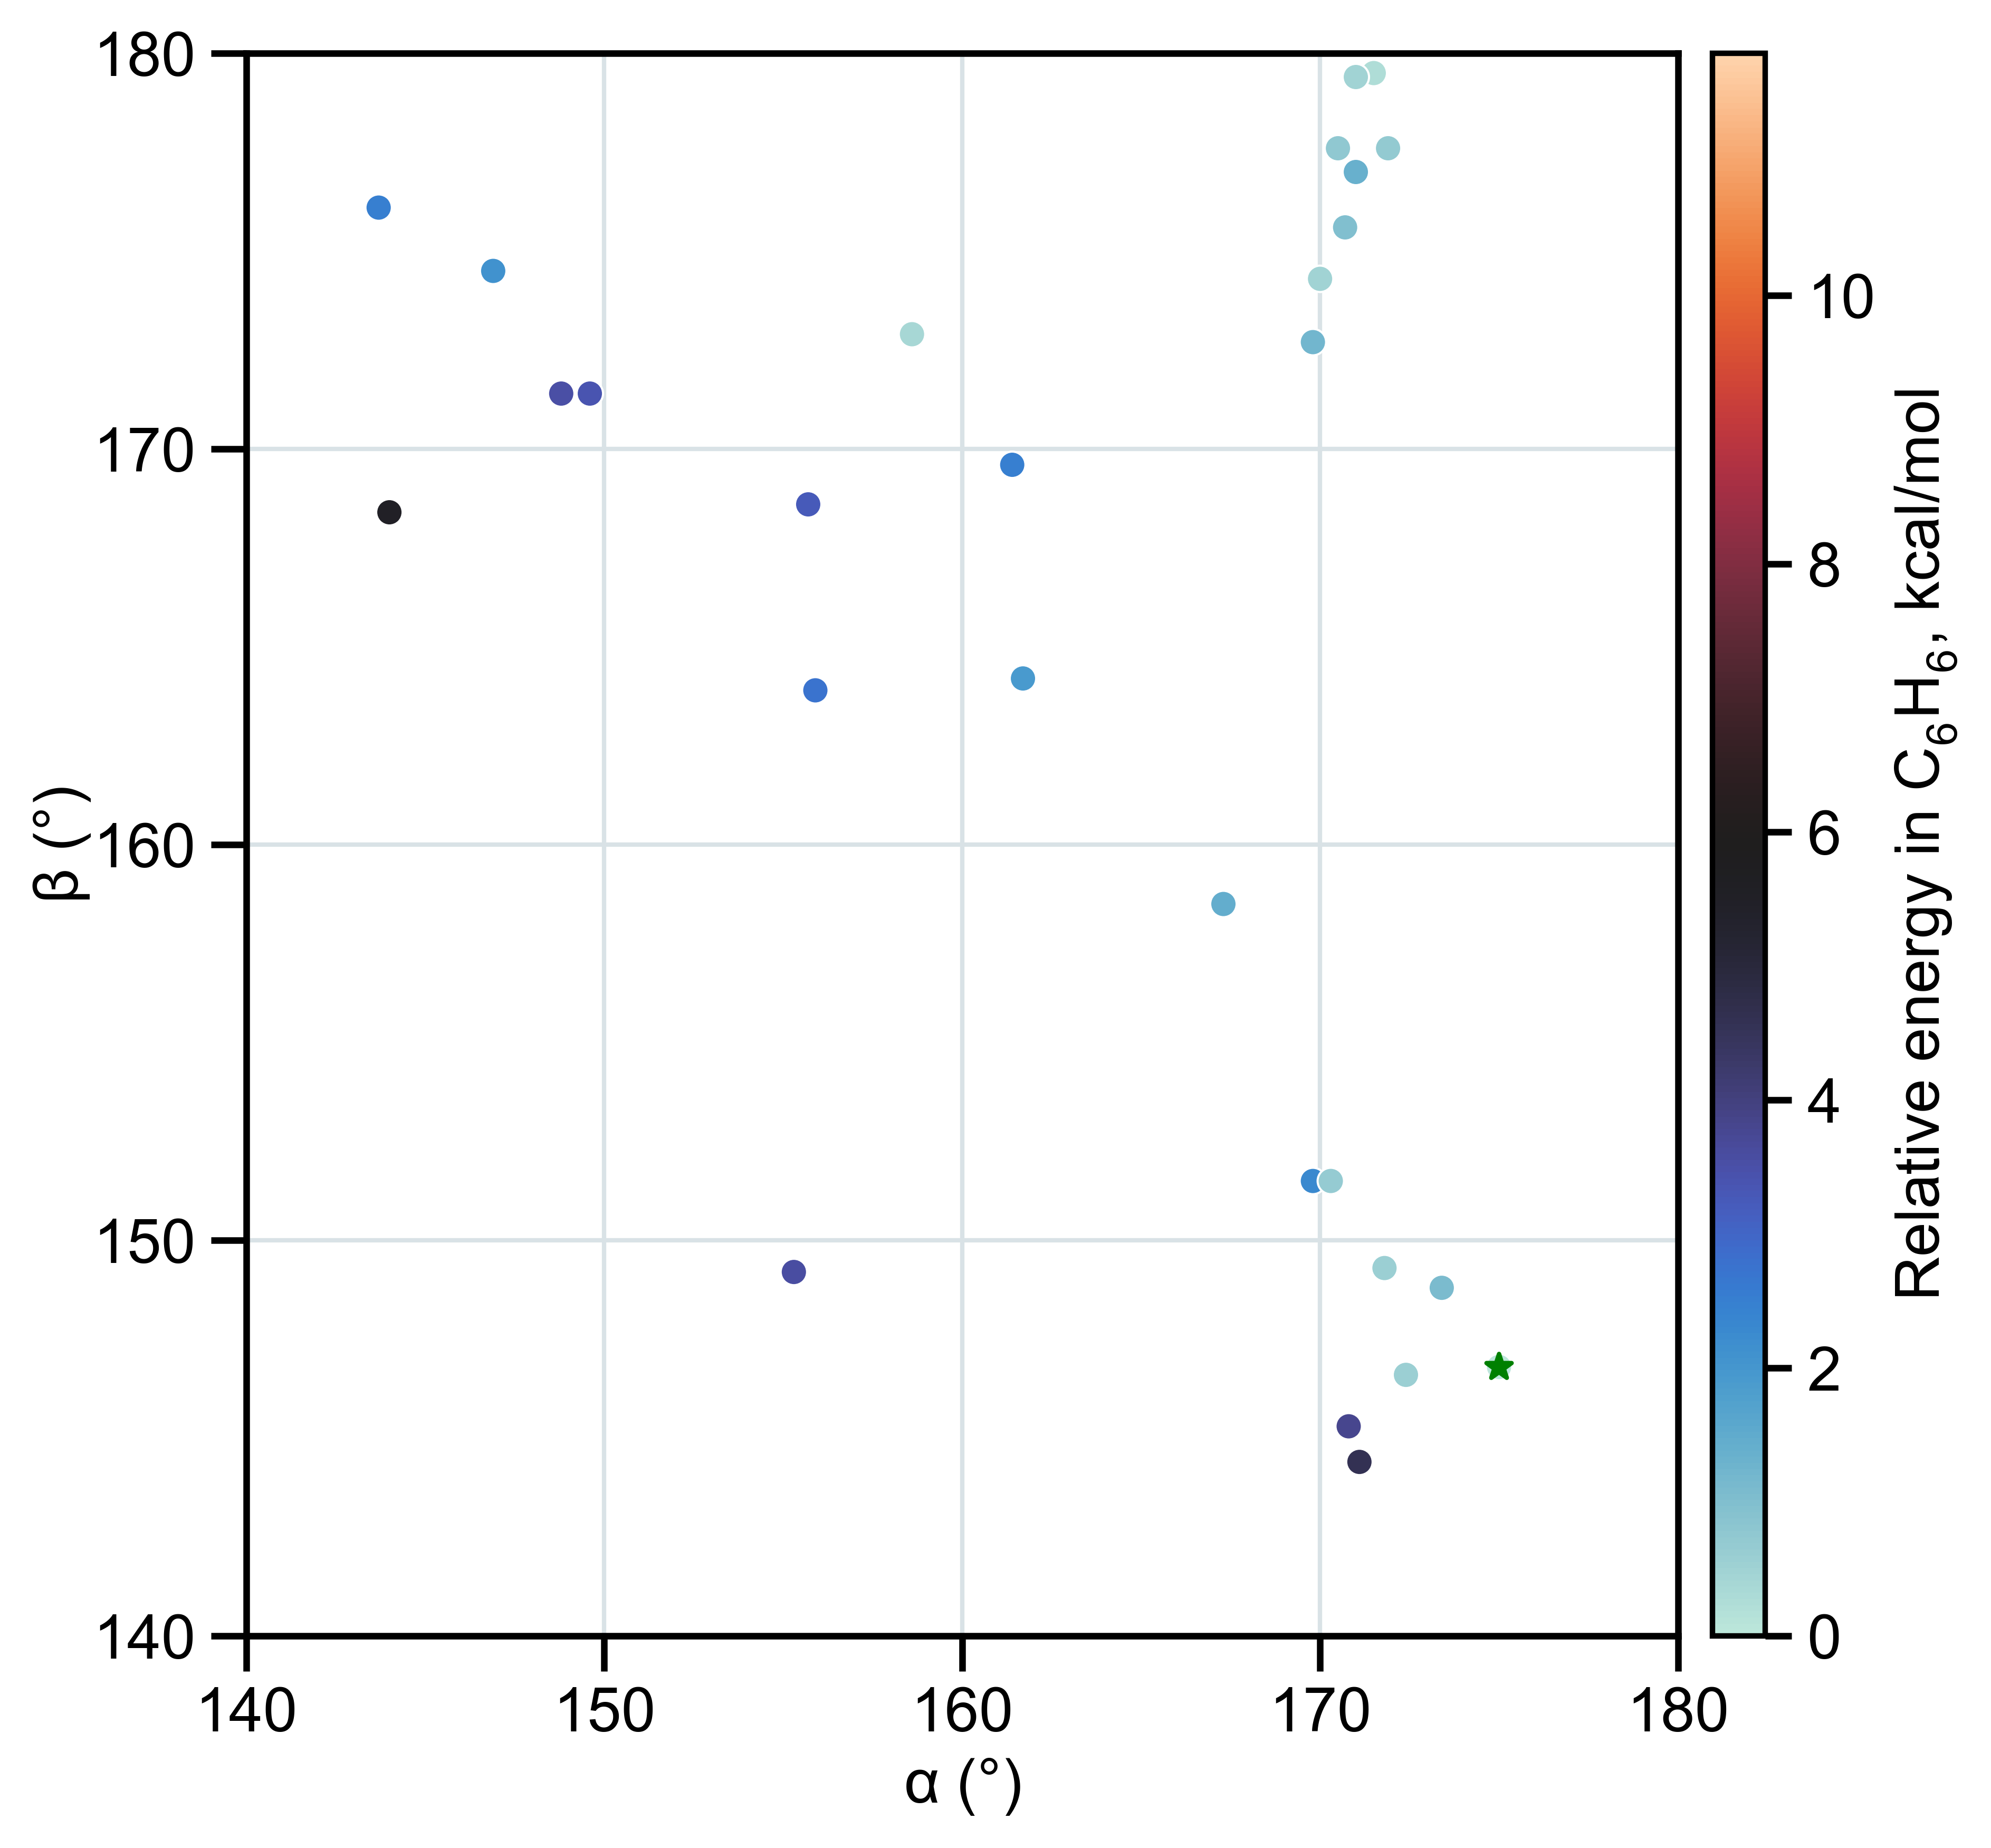

In [81]:

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.fontset"] = 'custom'
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.bf"] = 'sans:bold'
plt.rcParams["mathtext.rm"] = 'serif'
fonts = {'fontsize': 14}

fig, ax = plt.subplots(figsize=(6.5, 6), dpi=600)
sns.scatterplot(data=final_df, x='alpha_opt', y='beta_opt', hue='rel_benzene', palette='icefire', zorder=5, clip_on=True)
plt.scatter(final_df.loc[final_df['name']=='structure_32', 'alpha_opt'], final_df.loc[final_df['name']=='structure_32', 'beta_opt'], color='green', zorder=10, marker='*')

ax.set_axisbelow(True)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.grid(visible=True, which='major', axis='both', lw=1, c='#d9e2e6')

ax.set_xticks([140,150,160,170, 180])
ax.set_yticks([140,150,160,170, 180])

plt.tick_params(direction='out', length=8, color='black', width=1.5, labelsize=14)
plt.xlim(140, 180)
plt.ylim(140, 180)


plt.xlabel(r'$\alpha$ (°)', **fonts, labelpad=3)
plt.ylabel(r'$\beta$ (°)', **fonts, labelpad=0.15)

ax.legend(**fonts, loc='best', title='Relative energy', title_fontsize=14)


norm = plt.Normalize(0, inp_out['rel_benzene'].max())
sm = plt.cm.ScalarMappable(cmap="icefire", norm=norm)
cbar=ax.figure.colorbar(sm, ax=ax, location='right', orientation='vertical', aspect=30, pad=.02)
cbar.ax.tick_params(labelsize=14, width=1.5)
cbar.set_label(label='Relative energy in C$_{6}$H$_{6}$, kcal/mol', size=14)



ax.get_legend().remove()

plt.tight_layout()

#plt.savefig('iPr_dft_energy_hue_zoomed_no_duplicates.svg', dpi='figure', format='svg', bbox_inches='tight')
plt.show()


In [82]:
final_df[final_df['name']=='structure_32']

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
0,structure_32,175.0,146.8,4.9,-4651.823922,2.04694,-4649.776982,-4651.846038,-4651.868306,-4651.877649,...,157.6,4.8,-311.154701,3.905622,1,0.0,0.0,1.359184,2.055719,3


In [83]:
final_df[final_df['name']=='structure_92']

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
32,structure_92,87.4,169.9,5.9,-4651.815597,2.045806,-4649.769791,-4651.839376,-4651.863327,-4651.873372,...,142.2,7.7,-311.13867,13.965627,0,4.512417,3.46887,3.771957,4.02798,2


In [84]:
final_df['cluster_opt'].value_counts()

1    18
2    13
3    10
0     6
Name: cluster_opt, dtype: int64